# Corporate Bullet Bond and Duration-Matched Treasury Pricing

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, DateType, TimestampType, FloatType, IntegerType
from pyspark.sql.functions import udf
from datetime import datetime as dt
import calendar
from pandas.tseries.offsets import MonthEnd, MonthBegin, BDay, CustomBusinessDay
from pandas.tseries.holiday import (AbstractHolidayCalendar, Holiday, USMartinLutherKingJr, USPresidentsDay, USMemorialDay, 
USLaborDay, USThanksgivingDay, nearest_workday)
from scipy.optimize import minimize_scalar, root_scalar
import time

## Spark Functions

In [2]:
def getWrdsDTypeDict(dirty_str):
    '''
    Parses string of WRDS Variable Description table copied directly from site
    
    Parameters:
    dirty_str (str): WRDS variable description table text when copied and pasted directly from site
    
    Returns:
    dtype_dict (dict): dictionary where keys are feature names and values are dtypes
    '''
    dtype_dict = {}
    str_lines = dirty_str.split("\n")
    
    for line in str_lines:
        line_contents = line.split("\t")
        dtype_dict[line_contents[0]] = line_contents[1]
        
    return dtype_dict


def wrdsToSparkDTypeDict(wrds_dtype_dict, force_custom=False):
    '''
    Converts data types from WRDS Variable Description table to equivalent Spark data type object
    
    Parameters:
    wrds_dtype_dict (dict): dictionary of WRDS variables (keys) and dtypes as they appear in WRDS (values)
    force_custom (bool): when True, any WRDS variables that satisfies a certain condition is forced to be cast as different spark dtype than
                         suggested by WRDS
    
    Returns:
    spark_dtype_dict (dict): dictionary of WRDS table features (keys) and dtype objects from spark.sql.types (values)
    '''
    spark_dtype_dict = {}
    wrds_to_spark_dtype_map = {
        "Char": StringType(),
        "Date": DateType(),
        "Float": FloatType(),
        "Time": TimestampType()
    }
    for feature, wrds_dtype in wrds_dtype_dict.items():
        spark_dtype_dict[feature] = wrds_to_spark_dtype_map[wrds_dtype]
        if force_custom: 
            #time variables are interpreted as strings by default by Spark
            if feature in ["trd_exctn_tm", "trd_rpt_tm"]:
                spark_dtype_dict[feature] = StringType()
            #these variables initially expressed as char type are best cast to ints
            if feature in ["days_to_sttl_ct", "naics_code"]:
                spark_dtype_dict[feature] = IntegerType()
            
    return spark_dtype_dict


def getSparkSchema(raw_csv_cols, dirty_wrds_str, force_custom=False):
    '''
    Obtains Spark DataFrame schema using variable names and WRDS variable description string
    
    Parameters:
    raw_csv_cols (list): column names obtained from reading csv with inferSchema=False (faster)
    dirty_wrds_str (str): WRDS variable descriptions table text when copied and pasted directly from site
    force_custom (bool): when True, any WRDS table feature that satisfies a certain condition is forced to be cast as different spark dtype 
                         than suggested by WRDS
    
    Returns:
    (schema, spark_dtype_dict, wrds_dtype_dict) ((StructType, dict, dict)): structype schema for WRDS csv loading, 
                                                                            dictionary of WRDS table features (keys) and dtype objects from 
                                                                            spark.sql.types (values), dictionary where keys are feature names 
                                                                            and values are dtypes
    
    '''
    wrds_dtype_dict = getWrdsDTypeDict(dirty_wrds_str)
    spark_dtype_dict = wrdsToSparkDTypeDict(wrds_dtype_dict, force_custom)
    schema = StructType([StructField(feature, spark_dtype_dict[feature], True) for feature in raw_csv_cols])
    
    return schema, spark_dtype_dict, wrds_dtype_dict

def sparkDTypeToStrMap(dict_of_dtypes, setting=0):
    '''
    Creates map that either facilitates saving or loading dictionary of variables and their corresponding Spark data type objects 
    
    Parameters:
    dict_of_dtypes (dict): dictionary where values are feature column names from TRACE or Mergent and values are spark dtype objects or 
                           str representations of them setting (int): 0 = object to string, 1 = string to object
    
    Returns:
    output_dict (dict): dictionary where values are feature column names from TRACE or MERGENT and values are the swapped spark dtype 
                        objects or str representations of them
    '''
    output_dict = {}
    str_to_obj_map = {
        "StringType": StringType(),
        "DateType": DateType(),
        "FloatType": FloatType(),
        "TimestampType": TimestampType(),
        "IntegerType": IntegerType()
    }
    for key, value in dict_of_dtypes.items():
        #setting 1 used when loading a dictionary
        if setting == 1:
            output_dict[key] = str_to_obj_map[value]
        #setting 0 used when saving a dictionary
        if setting == 0:
            if value == StringType():
                output_dict[key] = "StringType"
            if value == DateType():
                output_dict[key] = "DateType"
            if value == FloatType():
                output_dict[key] = "FloatType"
            if value == TimestampType():
                output_dict[key] = "TimestampType"
            if value == IntegerType():
                output_dict[key] = "IntegerType"
                
    return output_dict

def getSparkSchema2(list_of_cols, json_folder_path, return_cols_by_origin=False):
    '''
    Obtain Spark schema from saved dictionary of variable names and data types
    
    Parameters:
    list_of_cols (list): list of variable column names
    json_folder_path (str): name of folder in which json files are stored
    return_cols_by_origin (bool): if True, returns dictionary where 'TRACE' and 'Mergent' are keys, and each value is the list 
                                  of variables according to whether they are from the TRACE or Mergent dataset 
                                  
    Returns:
    (df_schema, cols_by_origin_dict) (StructType, dict): Spark schema for DataFrame, dictionary of variable lists according to dataset origin
    '''
    with open(json_folder_path + "trace_spark_dtype_dict.json","r") as file:
        trace_spark_dtype_str_dict = json.load(file)
    trace_spark_dtype_dict = sparkDTypeToStrMap(trace_spark_dtype_str_dict, 1)
    
    with open(json_folder_path + "mergent_spark_dtype_dict.json","r") as file:
        mergent_spark_dtype_str_dict = json.load(file)
    mergent_spark_dtype_dict = sparkDTypeToStrMap(mergent_spark_dtype_str_dict, 1)

    #new dictionary to be used to generate output schema
    df_spark_dtype_dict = {}
    for col in list_of_cols:
        if col in trace_spark_dtype_dict.keys():
            df_spark_dtype_dict[col] = trace_spark_dtype_dict[col]
            
        else:
            df_spark_dtype_dict[col] = mergent_spark_dtype_dict[col]
            
    df_schema = StructType([StructField(col,df_spark_dtype_dict[col], True) for col in df_spark_dtype_dict.keys()])
    
    if return_cols_by_origin:
        cols_by_origin_dict = {}
        trace_cols = list(set(list_of_cols) & set(list(trace_spark_dtype_dict.keys())))
        mergent_cols = list(set(list_of_cols) & set(list(mergent_spark_dtype_dict.keys())))
        cols_by_origin_dict["trace"] = trace_cols
        cols_by_origin_dict["mergent"] = mergent_cols
        
        return df_schema, cols_by_origin_dict
        
    return df_schema, None

def fixNAICSToInt(naics):
    '''
    If the NAICS code string is smaller than 6 characters, append a 0 (appears to be common entry error)
    
    Paramters:
    naics (str): string of NAICS code
    
    Returns:
    naics_str: naics code string with appended 0
    '''
    if naics is None:
        return None
        
    naics_str = str(naics)
    
    if len(naics_str) < 6:
        naics_str = naics_str.ljust(6, "0")
        
    return int(naics_str)

## Pricing Functions

In [3]:
class CustomUSHolidayCalendar(AbstractHolidayCalendar):
    #class that inherits AbstractHolidayCalendar class, but with rules set to accomodate trading holidays 
    rules = [
        Holiday("NewYearsDay", month=1, day=1, observance=nearest_workday),
        USMartinLutherKingJr,
        USPresidentsDay,
        USMemorialDay,
        Holiday("Juneteenth", month=6, day=19, start_date="2021-01-01", observance=nearest_workday),
        Holiday("IndependenceDay", month=7, day=4, observance=nearest_workday),
        USLaborDay,
        USThanksgivingDay, 
        Holiday("Christmas", month=12, day=25, observance=nearest_workday)
    ]
    

def getTradingDaysObject():
    '''
    Creates pandas CustomBusinessDay object with trading holiday dates generated over sample period

    Returns:
    CustomBusinessDay object: object that can differentiate between valid trading days and holidays/weekends
    '''
    calendar_object = CustomUSHolidayCalendar()
    trading_holidays = calendar_object.holidays(start="2002-01-01", end="2025-12-31") 
    
    return CustomBusinessDay(holidays=trading_holidays)
    

def marketHoursTimestampRestriction(timestamps):
    '''
    Floors/Caps any trade execution times outside typical market hours to 9:30AM/4:00PM (price distortion may be minimal in current framework,
                                                                                         restriction done to keep data points)

    Paramters:
    timestamps (pd.Series): series of all trade execution timestamps
    
    Returns:
    restricted_timestamps (pd.Series): series of all trade execution timestamps restricted to typical market hours
    '''
    market_open_timestamps = pd.to_datetime({
        "year": timestamps.dt.year,
        "month": timestamps.dt.month,
        "day": timestamps.dt.day,
        "hour": 9,
        "minute": 30,
        "second": 0
    })
    market_close_timestamps = pd.to_datetime({
        "year": timestamps.dt.year,
        "month": timestamps.dt.month,
        "day": timestamps.dt.day,
        "hour": 16,
        "minute": 0,
        "second": 0
    })
    
    early_mask = (timestamps.dt.hour < 9) | ((timestamps.dt.hour == 9) & (timestamps.dt.minute < 30))
    late_mask = (timestamps.dt.hour > 16) | ((timestamps.dt.hour == 16) & (timestamps.dt.minute > 0))
    restricted_timestamps = timestamps.copy()
    restricted_timestamps[early_mask] = market_open_timestamps[early_mask]
    restricted_timestamps[late_mask] = market_close_timestamps[late_mask]
    
    return restricted_timestamps
    
    
def get30360PaymentSchedule(dated_date, first_interest_date, last_interest_date, maturity, months_per_period, 
                            trading_days_cbd_object):
    '''
    Creates a list of tuples all nominal and actual payment dates of a bond issue given its dated date, first interest date, last interest 
    date, and maturity date, provided in the Mergent dataset

    The actual payment date is the nominal payment date rolled forward to the nearest trading day

    Parameters:
    dated_date (datetime64[ns]): bond issue dated date
    first_interst_date (datetime64[ns]): bond issue first interest payment date
    lasT_interest_date (datetime64[ns]): bond issue last interest payment date
    maturity (datetime64[ns]): bond issue maturity date
    annual_periodicity (int): number of coupon payments per year
    trading_days_cbd_obect (CustomBusinessDay object): CustomBusinessDay object that can differentiate between valid trading days and 
                                                       holidays/weekends
    
    Returns:
    payment_schedule_list (list): list of tuples of bond issue's nominal and actual payment date timestamps
    '''
    payment_schedule_list = []
    temp_pymnt_date = first_interest_date
    temp_act_pymnt_date = first_interest_date
    
    while temp_pymnt_date <= last_interest_date:
        temp_act_pymnt_date = trading_days_cbd_object.rollforward(temp_pymnt_date)
        payment_schedule_list.append((temp_pymnt_date, temp_act_pymnt_date))
        temp_pymnt_date += pd.DateOffset(months=months_per_period)

    temp_act_pymnt_date = trading_days_cbd_object.rollforward(maturity)
    payment_schedule_list.append((maturity, temp_act_pymnt_date))
    
    return payment_schedule_list
    

def group30360PaymentSchedule(group, months_per_period, global_payment_schedule_dict, trading_days_cbd_object):
    '''
    Mutator function that updates a globally declared dictionary with each bond issue's 30/360 payment schedule list; this function
    is applied to groups obtained by grouping a DataFrame by complete_cusip

    Parameters:
    group (pandas group object): sub DataFrame for corresponding complete_cusip
    annual_periodicity (int): number of coupon payments per year
    global_payment_schedule_dict (dict): globally declared dictionary to be mutated
    trading_days_cbd_obect (CustomBusinessDay object): CustomBusinessDay object that can differentiate between valid trading 
                                                       days and holidays/weekends
    
    Returns:
    None
    '''
    row = group.iloc[0]
    curr_payment_schedule = get30360PaymentSchedule(
        row["dated_date"], 
        row["first_interest_date"],
        row["last_interest_date"],
        row["maturity"],
        months_per_period,
        trading_days_cbd_object
    )
    global_payment_schedule_dict[row["complete_cusip"]] = curr_payment_schedule
    
    return None
    

def savePaymentScheduleDict(file_name, global_payment_schedule_dict):
    '''
    Saves the globally declared payment schedule dictionary

    Parameters: 
    file_name (str): file name for json file
    global_payment_schedule_dict (dict): globally declared dictionary of payment schedules
    
    Returns:
    None
    '''
    dict_copy = {}
    
    for complete_cusip, payment_schedule_list in global_payment_schedule_dict.items():
        new_list = []
        
        for timestamp_tuple in payment_schedule_list:
            #tuples converted to ISO string format
            new_tuple = (timestamp_tuple[0].isoformat(), timestamp_tuple[1].isoformat())
            new_list.append(new_tuple)
            
        dict_copy[complete_cusip] = new_list
        
    with open(file_name, "w") as file:
        json.dump(dict_copy, file)
    print("SAVED PAYMENT SCHEDULE DICT")
    
    return None


def loadPaymentScheduleDict(file_name):
    '''
    Loads from json file the globally declared payment schedule dictionary

    Parameters:
    file_name (str): name of json file to load in
    
    Returns:
    None
    '''
    with open(file_name, "r") as file:
        new_payment_schedule_dict = json.load(file)
        
    for complete_cusip, payment_schedule_list in new_payment_schedule_dict.items():
        new_list = []

        #json files save tuples as lists
        for timestamp_list in payment_schedule_list:
            new_tuple = (pd.Timestamp(timestamp_list[0]), pd.Timestamp(timestamp_list[1]))
            new_list.append(new_tuple)
            
        new_payment_schedule_dict[complete_cusip] = new_list
        
    return new_payment_schedule_dict
    

def isPaymentDay(payment_date_list, date):
    '''
    Determines if a timestamp date occurs on a bond issue's actual payment date

    Parameters:
    payment_date_list (list): list of tuples of bond issue's nominal and actual payment date timestamps
    date (datetime64[ns]): date timestamp to be tested 
    
    Returns:
    (bool): True if is an actual payment date, False otherwise
    '''
    for timestamp_tuple in payment_date_list:

        temp_act_pymnt_date = timestamp_tuple[1]
        is_payment_day = ((date.year == temp_act_pymnt_date.year) and \
                   (date.month == temp_act_pymnt_date.month) and \
                   (date.day == temp_act_pymnt_date.day)
                  )
        if is_payment_day:
            
            return True
            
    return False
    

def yearsElapsed30360DayCount(start_date, end_date):
    '''
    Calculates years elapsed between two dates using the ISDA 30U/360 US day count convention with EOM convention always on; 
    conditions are applied in the order provided by ISDA, carrying any adjusted days over to following conditions
    (uses linear intraday accrual with second-level granularity)

    Parameters:
    start_date (datetime[ns]): start date timestamp
    end_date (datetime[ns]): end date timestamp

    Returns:
    max(0, years_elapsed) (float): time in years between the dates using 30/360 daycount convention
    '''
    #initial check to avoid negative time differences
    if end_date <= start_date:
        return 0
        
    start_year = start_date.year
    start_month = start_date.month
    start_day = start_date.day
    end_year = end_date.year
    end_month = end_date.month
    end_day = end_date.day
    
    #first two february ISDA conditions in order
    if (start_month == 2) and (start_date.is_month_end):
        if (end_month == 2) and (end_date.is_month_end):
            end_day = 30
        start_day = 30
        
    #penultimate ISDA condition 
    if (end_day == 31) and (start_day > 29):
        end_day = 30

    #final ISDA condition
    if start_day == 31:
        start_day = 30

    year_days_elapsed = (end_year - start_year) * 360
    month_days_elapsed = (end_month - start_month) * 30
    day_days_elapsed = end_day - start_day
    hour_days_elapsed = (end_date.hour - start_date.hour) / 24
    minute_days_elapsed = (end_date.minute - start_date.minute) / 1440
    second_days_elapsed = (end_date.second - start_date.second) / 86400
    
    years_elapsed = (year_days_elapsed + \
                    month_days_elapsed + \
                    day_days_elapsed + \
                    hour_days_elapsed + \
                    minute_days_elapsed + \
                    second_days_elapsed
                   ) / 360

    #final check to avoid any potential negative time differences
    return max(0, years_elapsed)

def yearsElapsedActualActualDayCount(start_date, end_date):
    '''
    Calculates years elapsed between two dates using the ISDA Actual/Actual daycount convention; 
    supports any time difference (uses linear intraday accrual with second-level granularity)

    Parameters:
    start_date (datetime[ns]): start date timestamp
    end_date (datetime[ns]): end date timestamp

    Returns:
    max(0, years_elapsed) (float): time in years between the dates using Actual/Actual daycount convention
    '''
    #initial check to avoid negative time differences
    if end_date <= start_date:
        return 0
    
    years_elapsed = 0    
    temp_date = start_date

    #loop that splits different years by January 1st and divides days elapsed by corresponding days per year
    while temp_date.year < end_date.year:
        next_jan_first = pd.Timestamp(year=temp_date.year + 1, 
                                      month=1, 
                                      day=1, 
                                      hour=0, 
                                      minute=0, 
                                      second=0)
        days_in_year = 366 if calendar.isleap(temp_date.year) else 365
        years_elapsed += (next_jan_first - temp_date).total_seconds() / (days_in_year * 86400)
        temp_date = next_jan_first

    days_in_year = 366 if calendar.isleap(temp_date.year) else 365
    years_elapsed += (end_date - temp_date).total_seconds() / (days_in_year * 86400)

    #final check to avoid any potential negative time differences
    return max(0, years_elapsed)
    

def calcAccruedInterest(coupon, periodicity, face_value, dated_date, asof_date, complete_cusip, 
                        global_payment_schedule_dict):
    '''
    Calculates Accrued Interest using "continuously compounded interest received so far" / "continuously compounded interest 
    expected in period" fraction instead of the "days elapsed" / "days in period" fraction

    Parameters:
    coupon (float): annual coupon rate in percentage terms
    periodicity (int): coupon payments per year
    face_value (float): face value of bond
    dated_date (datetime64[ns]): dated date of bond
    asof_date (datetime64[ns]): trade execution date and time
    complete_cusip (str): complete cusip of bond issue
    global_payment_schedule_dict (dict): globally declared dictionary of payment schedules

    Returns:
    acc_amt (float): accrued interest since last coupon payment (or dated date)
    '''
    #get bond issue's payment schedule list
    pymnt_dt_list = global_payment_schedule_dict[complete_cusip]
    maturity = pymnt_dt_list[-1][1]

    acc_amt = 0

    #set accrued interest to 0 on payment dates
    if isPaymentDay(pymnt_dt_list, asof_date):
        return acc_amt

    #check if trade occurs during a valid interest accrual period
    if (asof_date >= dated_date) and (asof_date <= maturity):

        reg_cpn = coupon / (periodicity * 100)
        #obtain the equivalent annual continuously compounded coupon rate
        cont_cpn = periodicity * (np.log(1 + reg_cpn))
        yrs_per_period = 1 / periodicity

        left_date = None
        right_date = None
        pymnt_dt_list = [(dated_date, dated_date)] + pymnt_dt_list
            
        for i in range(1,len(pymnt_dt_list)):
            left_date = pymnt_dt_list[i-1][1]
            right_date = pymnt_dt_list[i][1]
            #determine current payment date interval
            if (asof_date >= left_date) and (asof_date <= right_date):
                break
                
        yrs_elapsed = yearsElapsed30360DayCount(left_date, asof_date)

        #avoid negative accrued interest values
        if yrs_elapsed == 0:
            return acc_amt

        #accrued interest calculation based on time elapsed in period 
        acc_amt =  (face_value * reg_cpn) * ((np.exp(cont_cpn * yrs_elapsed) - 1) / \
                                             (np.exp(cont_cpn * yrs_per_period) - 1))
            
    return acc_amt
    

def calcAccruedInterestLinear(coupon, periodicity, face_value, dated_date, asof_date, complete_cusip, 
                              global_payment_schedule_dict):
    '''
    Calculates Accrued Interest using "days elapsed" / "days in period" fraction

    Parameters:
    coupon (float): annual coupon rate in percentage terms
    periodicity (int): coupon payments per year
    face_value (float): face value of bond
    dated_date (datetime64[ns]): dated date of bond
    asof_date (datetime64[ns]): trade execution date and time
    complete_cusip (str): complete cusip of bond issue
    global_payment_schedule_dict (dict): globally declared dictionary of payment schedules

    Returns:
    acc_amt (float): accrued interest since last coupon payment (or dated date)
    '''
    #get bond issue's payment schedule list
    pymnt_dt_list = global_payment_schedule_dict[complete_cusip]
    maturity = pymnt_dt_list[-1][1]

    acc_amt = 0

    #set accrued interest to 0 on payment dates
    if isPaymentDay(pymnt_dt_list, asof_date):
        return acc_amt
        
    #check if trade occurs during a valid interest accrual period
    if (asof_date >= dated_date) and (asof_date <= maturity):


        reg_cpn = coupon / (periodicity * 100)
        #obtain the equivalent annual continuously compounded coupon rate
        cont_cpn = periodicity * (np.log(1 + reg_cpn))
        yrs_per_period = 1 / periodicity

        left_date = None
        right_date = None
        pymnt_dt_list = [(dated_date, dated_date)] + pymnt_dt_list
            
        for i in range(1,len(pymnt_dt_list)):
            left_date = pymnt_dt_list[i-1][1]
            right_date = pymnt_dt_list[i][1]
            #determine current payment date interval
            if (asof_date >= left_date) and (asof_date <= right_date):
                break
                
        yrs_elapsed = yearsElapsed30360DayCount(left_date, asof_date)

        #avoid negative accrued interest values
        if yrs_elapsed == 0:
            return acc_amt
            
        #accrued interest calculation based on time elapsed in period 
        acc_amt =  (face_value * reg_cpn) * (yrs_elapsed/yrs_per_period)
            
    return acc_amt
    

def bulletBondPricer(ytm, coupon, periodicity, face_value, asof_date, complete_cusip, global_payment_schedule_dict):
    '''
    Calculates price of a corporate bond using equivalent continuously compounded yield to maturity

    Parameters:
    ytm (float): annualized yield to maturity in percentage terms
    coupon (float): annual coupon rate in percentage terms
    periodicity (int): coupon payments per year
    face_value (float): face value of bond
    asof_date (datetime64[ns]): trade execution date and time
    complete_cusip (str): complete cusip of bond issue
    global_payment_schedule_dict (dict): globally declared dictionary of payment schedules

    Returns:
    trsy_price (float): price of duration-matched Treasury
    '''
    cpn = coupon / (periodicity * 100)
    yld = ytm / (periodicity * 100)
    #obtain the equivalent annual continuously compounded yield
    cont_yld = periodicity * (np.log(1 + yld))
    pymnt_dt_list = global_payment_schedule_dict[complete_cusip]

    price = 0

    for i in range(len(pymnt_dt_list)):
        
        if asof_date <= pymnt_dt_list[i][1]:
            
            yrs_to_cf = yearsElapsed30360DayCount(asof_date, pymnt_dt_list[i][1])
            #if the years to next cash flow is 0, skip to next cash flow date
            if yrs_to_cf == 0:
                continue
            #include face value if the date is the maturity date
            if i == len(pymnt_dt_list) - 1:
                cf = (cpn + 1) * face_value
            else:
                cf = cpn * face_value
            #discount the cash flow using the continuously compounded yield
            price += cf * np.exp(-yrs_to_cf * cont_yld)
    
    return price
    

def svenssonZeroCouponYield(n_years, beta0, beta1, beta2, beta3, tau1, tau2):
    '''
    Returns Nelson-Siegel-Svensson Treasury yield curve value for any maturity in years for a given day's parameters

    Parameters:
    n_years (float): years to maturity input for yield curve
    beta0 (float): beta0 parameter for model
    beta1 (float): beta1 parameter for model
    beta2 (float): beta2 parameter for model
    beta3 (float): beta3 parameter for model
    tau1 (float): tau1 parameter for model
    tau2 (float): tau2 parameter for model

    Returns:
    yld (float): yield curve value for given parameters 
    '''
    terma = n_years/tau1
    termb = n_years/tau2

    #bounds to restrict extreme values and avoid numerical errors between the 0 and 1 yr to maturity interval
    if abs(terma) < 1e-8:
        terma = np.sign(terma) * 1e-8
    if abs(termb) < 1e-8:
        termb = np.sign(termb) * 1e-8
    if abs(terma) > 1e8:
        terma = np.sign(terma) * 1e8
    if abs(termb) > 1e8:
        termb = np.sign(termb) * 1e8

    #calculating yield according to model
    term1 = beta0
    term2 = beta1 * ((1-np.exp(-terma))/terma)
    term3 = beta2 * (((1-np.exp(-terma))/terma)-np.exp(-terma))
    term4 = beta3 * (((1-np.exp(-termb))/termb)-np.exp(-termb))
    yld = term1 + term2 + term3 + term4

    return yld
    

def durationMatchedTreasuryPrice(coupon, periodicity, face_value, asof_date, b0, 
                                  b1, b2, b3, t1, t2, complete_cusip, global_payment_schedule_dict):
    '''
    Calculates price of a corporate bond's duration-matched Treasury using the Svensson yield curve paramters
    corresponding to the asof_date (pricer proposed by Binsbergen, et al. 2021)

    Parameters:
    coupon (float): annual coupon rate in percentage terms
    periodicity (int): coupon payments per year
    face_value (float): face value of bond
    asof_date (datetime64[ns]): trade execution date and time
    b0 (float): beta0 parameter for Svensson model
    b1 (float): beta1 parameter for Svensson model
    b2 (float): beta2 parameter for Svensson model
    b3 (float): beta3 parameter for Svensson model
    t1 (float): tau1 parameter for Svensson model
    t2 (float): tau2 parameter for Svensson model
    complete_cusip (str): complete cusip of bond issue
    global_payment_schedule_dict (dict): globally declared dictionary of payment schedules

    Returns:
    trsy_price (float): price of duration-matched Treasury
    '''
    cpn = coupon / (periodicity * 100)
    pymnt_dt_list = global_payment_schedule_dict[complete_cusip]
    
    trsy_price = 0

    for i in range(len(pymnt_dt_list)):

        if asof_date <= pymnt_dt_list[i][1]:
            
            yrs_to_cf = yearsElapsedActualActualDayCount(asof_date, pymnt_dt_list[i][1])
            #if the years to next cash flow is 0, skip to next cash flow date
            if yrs_to_cf == 0:
                continue
            #include face value if the date is the maturity date
            if i == len(pymnt_dt_list) - 1:
                cf = (cpn + 1) * face_value
            else:
                cf = cpn * face_value
            #discount the cash flow using the Svensson model yield
            zc_trsy_yld = svenssonZeroCouponYield(yrs_to_cf,b0,b1,b2,b3,t1,t2) / 100
            trsy_price += cf * np.exp(-yrs_to_cf * zc_trsy_yld)

    return trsy_price


def bulletBondYieldExtractor(dirty_price, coupon, periodicity, face_value, asof_date, complete_cusip, 
                             global_payment_schedule_dict, global_root_scalar_fail_identifier_list,
                             global_minimize_scalar_fail_identifier_list):
    '''
    Solves for annualized yield to maturity in percentage terms for a bond given its characteristics

    Paramters:
    dirty_price (float): dirty price of bond
    coupon (float): annual coupon rate in percentage terms
    periodicity (int): coupon payments per year
    face_value (float): face value of bond
    asof_date (datetime64[ns]): trade execution date and time
    complete_cusip (str): complete cusip of bond issue
    global_payment_schedule_dict (dict): globally declared dictionary of payment schedules
    global_root_scalar_fail_identifier_list (list): globally declared list of tuples of the form (complete_cusip, asof_date)
                                                    to identify data points that cause the root scalar solver to fail
    global_minimize_scalar_fail_identifier_list (list): globally declared list of tuples of the form (complete_cusip, asof_date)
                                                        to identify data points that cause the minimize scalar solver to fail

    Returns:
    float: annualized yield to maturity in percentage terms (NaN if neither solver works)
    '''
    #pricing error function that calls the bulletBondPricer and returns the difference between the calculated price and target price
    def pricing_error(ytm):
        price = bulletBondPricer(
            ytm,
            coupon,
            periodicity,
            face_value,
            asof_date,
            complete_cusip,
            global_payment_schedule_dict
        )
        return price - dirty_price
    #upper and lower bounds for yield output (min is 1 pip, max is 10,000 which is slightly above the max observed in the sample)
    lower_bound = 0.0001
    upper_bound = 10000.0

    #first try to find the yield using the root scalar solver with brentq settings
    try:
        result_1 = root_scalar(
            pricing_error,
            method='brentq',
            bracket=[lower_bound, upper_bound],
            xtol=1e-8
        )
        #only return result if solver converges or it solution is finite
        if result_1.converged and np.isfinite(result_1.root):
            return result_1.root
    #if root scalar solver fails, move on to minimize scalar solver
    except:
        pass
    #record any data point that caused the root scalar solver to fail
    global_root_scalar_fail_identifier_list.append((complete_cusip, asof_date))

    #use the square of the pricing error function to minimize magnitude of error, use bounds for quicker solve
    try:
        result_2 = minimize_scalar(
            lambda y: abs(pricing_error(y)),
            bounds=(lower_bound, upper_bound),
            method="bounded"
        )
        #only return result if solver finds finite solution
        if result_2.success and np.isfinite(result_2.x):
            return result_2.x
    except:
        pass
    #record any data point that caused both solvers to fail
    global_minimize_scalar_fail_identifier_list.append((complete_cusip, asof_date))

    #return NaN if no solution is found
    return np.nan




## Auxilliary Functions

In [4]:
def plotTargetPriceVSolvedPrices(df_row_example, estimated_dirty_price_col):
    '''
    Creates a plot of a bond's estimated price (red), the TRACE yield implied price (black), and a price curve w.r.t yield on a given date;
    if only the red line is visible, then the prices are practically equal

    This function is used to gauge the robustness of the entire framework used for pricing

    Paramters:
    df_row_example (pd.Series): row of sample DataFrame corresponding to one daily transaction for a given bond issue
    estimated_dirty_price_col (str): name of column of estimated dirty price (accomodates the original or re-calculated estimated price columns)

    Returns:
    None
    '''
    #obtain the price curve w.r.t yield
    yields = np.linspace(0.0001, 10, 500)
    prices = [bulletBondPricer(
        yld,
        df_row_example["coupon"],
        2,
        df_row_example["principal_amt"],
        df_row_example["trd_exctn_dt_tm_capped"],
        df_row_example["complete_cusip"],
        payment_schedule_dict
    ) for yld in yields]

    plt.figure(figsize=(6,4), dpi=100)
    plt.plot(yields, prices)
    #plot the TRACE yield implied price with a black dashed horizontal line
    plt.axhline(df_row_example["trace_dirty_price"], color = "black", linestyle = "--", label = "TRACE Dirty Price")
    #plot the estimated price with a red dashed horizontal line
    plt.axhline(df_row_example[estimated_dirty_price_col], color = "red", linestyle = "--", label = "Estimated Dirty Price")
    plt.xlabel("Yield", fontsize=8)
    plt.xticks(fontsize=8)
    plt.ylabel("Bond Price", fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(f"Bond Price vs Yield: Complete_Cusip-{df_row_example['complete_cusip']}, Date-{df_row_example['trd_exctn_dt_tm_capped']}", fontsize=10)
    plt.grid(True)
    plt.legend(fontsize=8)
    plt.show()

# Bond Transaction Data Preparation (Spark)

## Data File Paths

In [5]:
#note, the trace_enhanced_clean.csv and fisd_bond_issue_data.csv files must be added to raw_data_folder to run notebook
raw_data_file_path = r"raw_data_folder\\"
processed_data_file_path = r"processed_data_folder\\"
json_file_path = r"json_folder\\"
os.makedirs(raw_data_file_path, exist_ok=True)
os.makedirs(processed_data_file_path, exist_ok=True)
os.makedirs(json_file_path, exist_ok=True)

## Launch Spark Session

In [6]:
import pyspark
print(pyspark.__version__)

#environment configurations for Spark session, allow for optional use of Ray
os.environ["HADOOP_HOME"] = r"C:\Users\wvill\hadoop"
os.environ["hadoop.home.dir"] = r"C:\Users\wvill\hadoop"
os.environ["HADOOP_OPTIONAL_TOOLS"] = "false"
os.environ["SPARK_DRIVER_MEMORY"] = "6g"
os.environ["SPARK_EXECUTOR_MEMORY"] = "6g"
os.environ["PYSPARK_PYTHON"] = r"C:\Users\wvill\AppData\Local\Programs\Python\Python311\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\wvill\AppData\Local\Programs\Python\Python311\python.exe"

print(os.getenv("HADOOP_HOME"))

spark = SparkSession.builder.appName("WRDS_CSV_Processor").config("spark.hadoop.io.native.lib.available", "false").getOrCreate()
spark.conf.get("spark.hadoop.io.native.lib.available")

3.5.5
C:\Users\wvill\hadoop


'false'

## TRACE and Mergent Variable Description Table Strings

In [7]:
#text directly from variable description table page on WRDS site for TRACE Enhanced Clean data and Mergent Bond Issue data 

trace_enhanced_dtype_str_dirty="""cusip_id	Char	CUSIP ID (cusip_id)
bond_sym_id	Char	TRACE Bond Symbol (bond_sym_id)
company_symbol	Char	Company Symbol (issuer stock ticker) (company_symbol)
trd_exctn_dt	Date	Execution Date (trd_exctn_dt)
trd_exctn_tm	Float	Execution Time (trd_exctn_tm)
trd_rpt_dt	Date	Report Date (trd_rpt_dt)
trd_rpt_tm	Float	Report Time (trd_rpt_tm)
msg_seq_nb	Char	Message Sequence Number (msg_seq_nb)
trc_st	Char	Trade Status (trc_st)
scrty_type_cd	Char	Security Type (scrty_type_cd)
wis_fl	Char	When Issued Indicator (wis_fl)
cmsn_trd	Char	Commission Indicator (cmsn_trd)
entrd_vol_qt	Float	Quantity (entrd_vol_qt)
rptd_pr	Float	Price (rptd_pr)
yld_sign_cd	Char	Yield Direction (yld_sign_cd)
yld_pt	Float	Yield (yld_pt)
asof_cd	Char	As Of Indicator (asof_cd)
days_to_sttl_ct	Char	Seller Sales Day (days_to_sttl_ct)
sale_cndtn_cd	Char	Sale Condition (sale_cndtn_cd)
sale_cndtn2_cd	Char	Second Modifier (sale_cndtn2_cd)
rpt_side_cd	Char	Buy/Sell Indicator (rpt_side_cd)
buy_cmsn_rt	Float	Buyer Commission (buy_cmsn_rt)
buy_cpcty_cd	Char	Buyer Capacity (buy_cpcty_cd)
sell_cmsn_rt	Float	Seller Commission (sell_cmsn_rt)
sell_cpcty_cd	Char	Seller Capacity (sell_cpcty_cd)
cntra_mp_id	Char	Contra Party Indicator (cntra_mp_id)
agu_qsr_id	Char	AGU Indicator (agu_qsr_id)
spcl_trd_fl	Char	Special Price Indicator (spcl_trd_fl)
trdg_mkt_cd	Char	Trading Market Indicator (trdg_mkt_cd)
dissem_fl	Char	Dissemination Flag (dissem_fl)
orig_msg_seq_nb	Char	Original Message Sequence Number (orig_msg_seq_nb)
bloomberg_identifier	Char	Bloomberg Identifier (bloomberg_identifier)
sub_prdct	Char	Sub-Product (sub_prdct)
stlmnt_dt	Date	Settlement Date (stlmnt_dt)
trd_mod_3	Char	Trade Modifier 3 (trd_mod_3)
trd_mod_4	Char	Trade Modifier 4 (trd_mod_4)
rptg_party_type	Char	Reporting Party Type (rptg_party_type)
lckd_in_ind	Char	Locked In Indicator (lckd_in_ind)
ats_indicator	Char	ATS Indicator (ats_indicator)
pr_trd_dt	Date	Prior Trade Report Date (pr_trd_dt)
first_trade_ctrl_date	Date	First Trade Control Date (first_trade_ctrl_date)
first_trade_ctrl_num	Char	First Trade Control Number (first_trade_ctrl_num)"""

mergent_bond_issue_dtype_str_dirty = """issue_id	Float	Issue ID (issue_id)
issuer_id	Float	Issuer ID (issuer_id)
issuer_id_affected	Float	Issuer ID (issuer_id_affected)
issuer_cusip	Char	Issuer CUSIP (issuer_cusip)
issue_cusip	Char	Issue CUSIP (issue_cusip)
complete_cusip	Char	Complete CUSIP (complete_cusip)
cusip_name	Char	CUSIP Name (cusip_name)
prospectus_issuer_name	Char	Prospectus Issuer Name (prospectus_issuer_name)
issue_name	Char	Issue Name (issue_name)
sedol	Char	SEDOL (sedol)
isin	Char	ISI Number (isin)
reallowance	Float	Reallowance (reallowance)
putable	Char	Putable (putable)
principal_amt	Float	Principal Amount (principal_amt)
press_release	Char	Press Release (press_release)
preferred_security	Char	Preferred Security (preferred_security)
perpetual	Char	Perpetual (perpetual)
overallotment_opt	Char	Overallotment Option (overallotment_opt)
oid	Char	Orig Issue Discount (oid)
offering_yield	Float	Offering Yield (offering_yield)
offering_price	Float	Offering Price (offering_price)
offering_date	Date	Offering Date (offering_date)
offering_amt	Float	Offering Amount (in thousands) (offering_amt)
mtn	Char	Medium Term Note (mtn)
maturity	Date	Maturity Date (maturity)
issue_offered_global	Char	Global Offer (issue_offered_global)
gross_spread	Float	Gross Spread (gross_spread)
fungible	Char	Fungible (fungible)
form_of_own	Char	Form of Ownership (form_of_own)
foreign_currency	Char	Foreign Currency (foreign_currency)
exchangeable	Char	Exchangeable (exchangeable)
enhancement	Char	Enhancement (enhancement)
dep_eligibility	Char	Eligible Depositories (dep_eligibility)
denomination	Char	Denomination (denomination)
delivery_date	Date	Delivery Date (delivery_date)
defeased_date	Date	Defeased Date (defeased_date)
defeased	Char	Defeased (defeased)
defeasance_type	Char	Defeasance Type (defeasance_type)
defaulted	Char	Defaulted (defaulted)
covenants	Char	Covenants (covenants)
coupon_type	Char	Coupon Type (coupon_type)
convertible	Char	Convertible (convertible)
comp_neg_exch_deal	Char	Type of Sale (comp_neg_exch_deal)
canadian	Char	Canadian Issuer (canadian)
bond_type	Char	Bond Type (bond_type)
asset_backed	Char	Asset Backed (asset_backed)
announced_call	Char	Announced Call (announced_call)
active_issue	Char	Active Issue (active_issue)
private_placement	Char	Private Placement (private_placement)
yankee	Char	Yankee (yankee)
unit_deal	Char	Unit Deal (unit_deal)
treasury_spread	Float	Treasury Spread (treasury_spread)
treasury_maturity	Char	Treasury Maturity (treasury_maturity)
tender_exch_offer	Char	Tender/Exchange Offer (tender_exch_offer)
subsequent_data	Char	Subsequent Data (subsequent_data)
slob	Char	SLOB (slob)
settlement_type	Char	Settlement Type (settlement_type)
selling_concession	Float	Selling Concession (selling_concession)
security_pledge	Char	Security Pledge (security_pledge)
security_level	Char	Security Level (security_level)
sec_reg_type2	Char	Additional SEC Registration Type (sec_reg_type2)
sec_reg_type1	Char	SEC Registration Type (sec_reg_type1)
rule_415_reg	Char	Rule 415 Registration (rule_415_reg)
rule_144a	Char	Rule 144a (rule_144a)
registration_rights	Char	Registration Rights (registration_rights)
refunding_date	Date	Refunding Date (refunding_date)
refund_protection	Char	Refund Protection (refund_protection)
redeemable	Char	Redeemable (redeemable)
determination_date	Date	The next date as of which the coupon for floating rate securities is calculated. (determination_date)
see_note	Char	Indicates that more detailed information on the coupon formula is included in the associated text footnote. (see_note)
reset_date_orig	Date	Represents the first date as of which the issue began to accrue interest at the first calculated coupon rate. (reset_date_orig)
reset_date	Date	The next date as of which the issue will begin to accrue interest at the new coupon rate. (reset_date)
lesser_of	Char	A flag indicating that the issues coupon resets to the lesser of the associated rate calculation formulas in the INDEX table. (lesser_of)
greater_of	Char	A flag indicating that the issues coupon resets to the greater of the associated rate calculation formulas in the INDEX table. (greater_of)
fix_frequency	Char	A four-letter code indicating how often the coupon will be reset. (fix_frequency)
determination_date_orig	Date	Represents the first date a new interest rate was calculated for this issue. (determination_date_orig)
pay_in_kind_exp_date	Date	Expiration date of the pay_in_kind option. (pay_in_kind_exp_date)
pay_in_kind	Char	Flag indicating that the interest on the issue may be paid in more of the same security, or in some cases, in other securities. (pay_in_kind)
last_interest_date	Date	Last interest payment date (last_interest_date)
interest_frequency	Char	Code indicating how often interest payments will be made. (interest_frequency)
first_interest_date	Date	Date on which first interest payment will be made to the bondholder. (first_interest_date)
day_count_basis	Char	Basis used for determining the interest paid during each interest period. (day_count_basis)
dated_date	Date	Date from which interest accrues or from which original issue discount is amortized. (dated_date)
coupon_change_indicator	Char	Indicates the issues coupon type, if not fixed. (coupon_change_indicator)
coupon	Float	The current applicable annual interest rate. (coupon)
soft_call_make_whole	Char	A flag indicating the soft call feature contains a make whole payment provision specified in the convertible_additional_terms table. (soft_call_make_whole)
shares_outstanding	Float	The total number of securities/shares of the conversion commodity outstanding (shares_outstanding)
reason	Char	The reason for the change of the convertible information on the change_date. (reason)
qty_of_commod	Float	The quantity of the conversion commodity (qty_of_commod)
percs	Char	A flag indicating the security has maximum payoff upon conversion specified in the convertible_additional_terms table. (percs)
percent_of_outstanding_commod	Float	The percentage of the total conversion commodity available through conversion. (percent_of_outstanding_commod)
peps	Char	A flag indicating the issue has additional conversion terms. (peps)
orig_shares_outstanding	Float	The total number of securities/shares of the conversion commodity when the issue was first offered. (orig_shares_outstanding)
orig_qty_of_commod	Float	The quantity of the conversion commodity that the bondholder would have received when the security was first offered. (orig_qty_of_commod)
orig_percent_outstanding_com	Float	The percentage of the total conversion commodity available through conversion of the issue when the issue was first offered. (orig_percent_outstanding_com)
orig_conv_price	Float	Conversion price of the conversion commodity when the issue was first offered. (orig_conv_price)
orig_conv_premium	Float	The percentage difference between the conversion price and the market price when the issue was first offered. (orig_conv_premium)
orig_commod_price	Float	Market price of the conversion commodity when the issue was first offered. (orig_commod_price)
exchange	Char	A four-letter code indicating the conversion commoditys principal securities exchange. (exchange)
dilution_protection	Char	A flag indicating whether or not the quantity of commodity will be adjusted for stock splits, dividends, distributions, or other specified events. (dilution_protection)
convert_on_call	Char	A flag indicating whether the holder is able to convert their security if it is called for redemption. (convert_on_call)
conv_total_trade_days	Float	Number of trading days during which the conversion commoditys price is measured for lifting redemption restrictions. (conv_total_trade_days)
conv_redemp_exception	Char	Flag indicating whether a soft call provision has been specified. (conv_redemp_exception)
conv_redemp_date	Date	End date of current soft call feature. (conv_redemp_date)
conv_prohibited_from	Date	Start date of current soft call feature. (conv_prohibited_from)
conv_price_percent	Float	Minimum percentage of the applicable conversion price at which the conversion commodity must trade at before restrictions on redemption are lifted. (conv_price_percent)
conv_price	Float	Conversion price of the conversion commodity. (conv_price)
conv_premium	Float	The percentage difference between the conversion price and the market price. (conv_premium)
conv_period_spec	Char	Indicates whether or not the bondholder must submit their security for conversion in a specified time period prior to redemption. (conv_period_spec)
conv_period_days	Float	Number of days prior to the announced redemption date that the bondholders are allowed to convert their bonds. (conv_period_days)
conv_part_trade_days	Float	The number of trading days that the conversion security must trade at or above a certain price to allow redemption. (conv_part_trade_days)
conv_exp_date	Date	Date on which conversion privilege expires. (conv_exp_date)
conv_eff_date	Date	First date on which issue may be converted. (conv_eff_date)
conv_commod_type	Char	A four-letter code indicating what the conversion commodity is. (conv_commod_type)
conv_commod_issuer	Char	The name of the issuer of the exchange commodity. (conv_commod_issuer)
conv_commod_cusip	Char	The CUSIP of the conversion commodity. (conv_commod_cusip)
conv_cash	Float	Additional cash payable by bondholder to effect conversion. (conv_cash)
conditional_conv_terms	Char	A flag indicating the security has conditional conversion terms specified in the convertible_additional_terms table. (conditional_conv_terms)
commod_price	Float	Market price of the conversion commodity. (commod_price)
change_date	Date	The date the current convertible information was added to the issue. (change_date)
as_of_date	Date	The date the current convertible information was added to the issue. (as_of_date)
ticker	Char	The ticker of the conversion commodity. (ticker)
split_ratio	Char	The ratio to which the conversion commodity was split. (split_ratio)
split_date	Date	The date of the last known conversion commodity split. (split_date)
sc_make_whole_start_date	Date	The date from which a soft call make-whole payment becomes payable if the bond is called for redemption. (sc_make_whole_start_date)
sc_make_whole_initial_amount	Float	The initial soft call make-whole payment amount that would be payable if the bond were called for redemption on the soft call make-whole start date. (sc_make_whole_initial_amount)
sc_make_whole_end_date	Date	The final date at which a soft call make-whole payment is payable if the bond is called for redemption. (sc_make_whole_end_date)
sc_make_whole_decrement_type	Char	A four-letter code indicating how the soft call make-whole payment decreases over time when the bond is called for redemption. (sc_make_whole_decrement_type)
sc_make_whole_change_percent	Float	The percentage (of the face value) by which the soft call make-whole payment payable is reduced on an annual basis if the bond is called for redemption. (sc_make_whole_change_percent)
percs_max_payoff	Float	Maximum payoff bondholder will receive upon conversion or at maturity per PERCS. (percs_max_payoff)
peps_min_conversion_ratio	Float	Minimum value of the conversion ratio. (peps_min_conversion_ratio)
peps_max_conversion_ratio	Float	Maximum value of the conversion ratio. (peps_max_conversion_ratio)
peps_lower_price	Float	Conversion commodity price at which maximum conversion ratio applies. (peps_lower_price)
peps_issue_price	Float	The face value or principal amount of the bond. (peps_issue_price)
peps_higher_price	Float	Conversion commodity price at which minimum conversion ratio applies. (peps_higher_price)
coco_trigger_expressed_as	Char	A four-letter code indicating how the coco_initial_trigger_percent is expressed. (coco_trigger_expressed_as)
coco_trade_days_in_previous	Char	The time period in which the coco_trade_days are measured. (coco_trade_days_in_previous)
coco_trade_days	Char	The number of trading days that the conversion commodity must trade at or above the trigger percent. (coco_trade_days)
coco_start_date	Date	Date at which conversion becomes conditional. (coco_start_date)
coco_min_trigger_level	Float	The lowest number the trigger percent will reach. (coco_min_trigger_level)
coco_initial_trigger_percent	Float	Stock price level initially required to trigger conditional conversion. (coco_initial_trigger_percent)
coco_end_date	Date	Last date that the conditional conversion terms apply. (coco_end_date)
coco_change_rate	Float	Annual percentage change of the coco_initial_trigger_percent. (coco_change_rate)
coco_change_frequency	Char	A four-letter code indicating the change frequency of the trigger percent. (coco_change_frequency)
action_type	Char	Action Type (action_type)
action_price	Float	Action Price (action_price)
action_amount	Float	Action Amount (action_amount)
effective_date	Date	Effective Date (effective_date)
amount_outstanding	Float	Amount Outstanding (amount_outstanding)
voting_power_percentage_erp	Float	Voting Power Percentage Erp (voting_power_percentage_erp)
voting_power_percentage	Float	Voting Power Percentage (voting_power_percentage)
rating_decline_trigger_put	Char	Rating Decline Trigger Put (rating_decline_trigger_put)
rating_decline_provision	Char	Rating Decline Provision (rating_decline_provision)
negative_pledge_covenant	Char	Negative Pledge Covenant (negative_pledge_covenant)
legal_defeasance	Char	Legal Defeasance (legal_defeasance)
economic_cov_def	Char	Economic Cov Def (economic_cov_def)
defeasance_wo_tax_conseq	Char	Defeasance w.o. Tax Conseq (defeasance_wo_tax_conseq)
declining_net_worth_trigger	Float	Declining Net Worth Trigger (declining_net_worth_trigger)
declining_net_worth_provisions	Char	Declining Net Worth Provisions (declining_net_worth_provisions)
declining_net_worth_percentage	Float	Declining Net Worth Percentage (declining_net_worth_percentage)
declining_net_worth	Char	Declining Net Worth (declining_net_worth)
cross_default	Char	Cross Default (cross_default)
cross_acceleration	Char	Cross Acceleration (cross_acceleration)
covenant_defeas_wo_tax_conseq	Char	Covenant Defeas w.o. Tax (covenant_defeas_wo_tax_conseq)
change_control_put_provisions	Char	Change Control Put Provisions (change_control_put_provisions)
asset_sale_clause	Char	Asset Sale Clause (asset_sale_clause)
after_acquired_property_clause	Char	After Acquired Property Clause (after_acquired_property_clause)
currency	Char	Currency (currency)
conversion_rate	Float	Conversion Rate (conversion_rate)
amt_offered	Float	Amount Offered (amt_offered)
settlement	Char	Settlement (settlement)
filing_date	Date	Filing Date (filing_date)
sec_cusip	Char	CUSIP of the other security offered as part of the unit. (sec_cusip)
quantity	Float	The quantity of other security offered with the unit. (quantity)
other_sec_type	Char	Type of the other security. (other_sec_type)
other_sec_issuer	Char	The name of the issuer of the other security. (other_sec_issuer)
market_price	Float	The market price of the units other security as of the issues offering date. (market_price)
date_transferable	Date	The date on which each security offered as part of the unit may be sold separately. (date_transferable)
date_subj_adjustment	Char	A flag indicating that the date on which the unit is free to trade as separate security is subject to adjustment. (date_subj_adjustment)
allocated_offering_price_other	Float	Portion of the unit price allocated to the non-debt, non-warrant security in the unit. (allocated_offering_price_other)
overallotment_expiration_date	Date	Overallotment Expiration Date (overallotment_expiration_date)
exercised_date	Date	Exercised Date (exercised_date)
exercised	Char	Exercised (exercised)
amount	Float	Amount (amount)
notification_period	Char	Notification Period (notification_period)
next_put_price	Float	Next Put Price (next_put_price)
next_put_date	Date	Next Put Date (next_put_date)
unit_cusip	Char	The CUSIP of the unit. (unit_cusip)
total_units_offered	Float	Total number of units offered. (total_units_offered)
principal_amt_per_unit	Float	The principal amount of each unit. (principal_amt_per_unit)
allocated_offering_price_unit	Float	From the prospectus, the value of the bond part of the unit. (allocated_offering_price_unit)
parent_id	Float	A number representing the agent_id of this issuers parent company. (parent_id)
naics_code	Char	The North American Industry Classification System code used to describe the business of this issuer. (naics_code)
industry_group	Char	A code indicating the industry group to which the issuer belongs. (industry_group)
industry_code	Char	A code indicating the industry to which the issuer belongs. (industry_code)
in_bankruptcy	Char	A flag denoting that the issuer is currently in bankruptcy. (in_bankruptcy)
esop	Char	A flag denoting that the issue will be repaid by pension contributions to an ESOP. (esop)
country_domicile	Char	The Country of Domicile or country of permanent residence of this issuer. (country_domicile)
agent_id	Float	A unique Mergent-generated number to identify each agent. (agent_id)
sic_code	Char	The firms four-digit Standard Industry Classification code. (sic_code)
transaction_affiliates	Char	Issuer is restricted in certain business dealings with its subsidiaries. (transaction_affiliates)
subordinated_debt_issuance	Char	Restricts issuance of junior or subordinated debt. (subordinated_debt_issuance)
stock_transfer_sale_disp	Char	Restricts the issuer from transferring, selling, or disposing of its own common stock or the common stock of a subsidiary. (stock_transfer_sale_disp)
stock_issuance_issuer	Char	Restricts issuer from issuing additional common stock. (stock_issuance_issuer)
senior_debt_issuance	Char	Restricts issuer to the amount of senior debt it may issue in the future. (senior_debt_issuance)
sales_leaseback_is	Char	Restricts issuer to the type or amount of property used in a sale leaseback transaction and may restrict its use of the proceeds of the sale. (sales_leaseback_is)
sale_assets	Char	Restrictions on the ability of an issuer to sell assets or restrictions on the issuers use of the proceeds from the sale of assets. (sale_assets)
restricted_payments	Char	Restricts issuers freedom to make payments (other than dividend related payments) to shareholders and others. (restricted_payments)
net_earnings_test_issuance	Char	To issue additional debt the issuer must have achieved or maintained certain profitability levels. (net_earnings_test_issuance)
maintenance_net_worth	Char	Issuer must maintain a minimum specified net worth. (maintenance_net_worth)
liens_is	Char	In the case of default, the bondholders have the legal right to sell mortgaged property to satisfy their unpaid obligations. (liens_is)
leverage_test_is	Char	Restricts total-indebtedness of the issuer. (leverage_test_is)
investments	Char	Restricts issuers investment policy to prevent risky investments. (investments)
indebtedness_is	Char	Restricts user from incurring additional debt with limits on absolute dollar amount of debt outstanding or percentage total capital. (indebtedness_is)
funded_debt_is	Char	Restricts issuer from issuing additional funded debt. (funded_debt_is)
fixed_charge_coverage_is	Char	Issuer is required to have a ratio of earnings available for fixed charges, of at least a minimum specified level. (fixed_charge_coverage_is)
dividends_related_payments_is	Char	Payments made to shareholders or other entities may be limited to a certain percentage of net income or some other ratio. (dividends_related_payments_is)
consolidation_merger	Char	A consolidation or merger of the issuer with another entity is restricted. (consolidation_merger)
subsidiary_redesignation	Char	Indicates if restricted subsidiaries may be reclassified as an unrestricted subsidiaries. (subsidiary_redesignation)
subsidiary_guarantee	Char	Subsidiary is restricted from issuing guarantees for the payment of interest and/or principal of certain debt obligations. (subsidiary_guarantee)
stock_issuance	Char	Restricts issuer from issuing additional common stock in restricted subsidiaries. (stock_issuance)
sales_leaseback_sub	Char	Restricts subsidiaries from selling then leasing back assets that provide security for the debtholder. (sales_leaseback_sub)
sale_xfer_assets_unrestricted	Char	Issuer must use proceeds from sale of subsidiaries assets to reduce debt. (sale_xfer_assets_unrestricted)
preferred_stock_issuance	Char	Restricts subsidiaries ability to issue preferred stock. (preferred_stock_issuance)
liens_sub	Char	Restricts subsidiaries from acquiring liens on their property. (liens_sub)
leverage_test_sub	Char	Limits subsidiaries leverage. (leverage_test_sub)
investments_unrestricted_subs	Char	Restricts subsidiaries investments. (investments_unrestricted_subs)
indebtedness_sub	Char	Restricts the total indebtedness of the subsidiaries. (indebtedness_sub)
funded_debt_sub	Char	Restricts issuers subsidiaries from issuing additional funded debt. (funded_debt_sub)
fixed_charge_coverage_sub	Char	Subsidiaries are required to maintain a minimum ratio of net income to fixed charges. (fixed_charge_coverage_sub)
dividends_related_payments_sub	Char	Limits the subsidiaries payment of dividends to a certain percentage of net income or some other ratio. (dividends_related_payments_sub)
borrowing_restricted	Char	Indicates subsidiaries are restricted from borrowing, except from parent. (borrowing_restricted)"""

## Loading TRACE Data

In [8]:
trace_df_raw = spark.read.csv(raw_data_file_path + "trace_enhanced_clean_data.csv", 
                              header=True, 
                              inferSchema=False)
trace_df_raw_cols = [x.lower() for x in trace_df_raw.columns]
trace_schema, trace_spark_dtype_dict, trace_wrds_dtype_dict = getSparkSchema(trace_df_raw_cols, 
                                                                             trace_enhanced_dtype_str_dirty, 
                                                                             force_custom=True)
del trace_df_raw
trace_df = spark.read.csv(raw_data_file_path + "trace_enhanced_clean_data.csv", 
                          schema=trace_schema, 
                          header=True)
trace_spark_dtype_str_dict = sparkDTypeToStrMap(trace_spark_dtype_dict,0)

with open(json_file_path + "trace_spark_dtype_dict.json", "w") as file:
    json.dump(trace_spark_dtype_str_dict, file)
    
trace_df.rdd.getNumPartitions()

333

## Loading Mergent Data

In [9]:
mergent_df_raw = spark.read.csv(raw_data_file_path + "fisd_bond_issue_data.csv", 
                                header=True, 
                                inferSchema=False)
mergent_df_raw_cols = [x.lower() for x in mergent_df_raw.columns]
mergent_schema, mergent_spark_dtype_dict, mergent_wrds_dtype_dict = getSparkSchema(mergent_df_raw_cols, 
                                                                                     mergent_bond_issue_dtype_str_dirty,
                                                                                     force_custom=True)
del mergent_df_raw
mergent_df = spark.read.csv(raw_data_file_path + "fisd_bond_issue_data.csv", 
                            schema=mergent_schema, 
                            header=True)
mergent_spark_dtype_str_dict = sparkDTypeToStrMap(mergent_spark_dtype_dict, 0)

with open(json_file_path + "mergent_spark_dtype_dict.json", "w") as file:
    json.dump(mergent_spark_dtype_str_dict, file)
    
mergent_df.rdd.getNumPartitions()

16

## Filters proposed by Binsbergen, et al. (2023)

### TRACE Filters

In [10]:
#remove bonds that are when-issued
when_issued_filter = F.col("wis_fl") != "Y"
#remove bonds that have special conditions
special_filter = (F.col("spcl_trd_fl") != "Y") | F.col("spcl_trd_fl").isNull()
#remove bonds that are locked in
locked_in_filter = (F.col("lckd_in_ind") != "Y") | F.col("lckd_in_ind").isNull()
#first filter to remove rows where days to settlement is greater than 2 before 2012
pre_2012_sub_filter = F.year("trd_exctn_dt") < 2012
days_to_settle_sub_filter = (F.col("days_to_sttl_ct") > 2) & F.col("days_to_sttl_ct").isNotNull()
pre_2012_days_to_settle_filter = ~(pre_2012_sub_filter & days_to_settle_sub_filter)
#second filter to remove rows where days to settlement is greater than 2 before 2012
days_to_settle_filter = ~((F.col("trd_exctn_dt").isNotNull()) &\
                         (F.col("stlmnt_dt").isNotNull()) &\
                         (F.datediff(F.col("stlmnt_dt"),F.col("trd_exctn_dt")) > 2) &\
                         (F.year(F.col("stlmnt_dt"))<2012))
#keep only corporate bonds (security code type of C, excluded NaN)
corporate_bond_filter = ~((F.col("scrty_type_cd")=="E") & F.col("scrty_type_cd").isNotNull())
#keep bonds that are traded on the seconday market
secondary_market_filter = F.col("trdg_mkt_cd")=="S1"
#keep bonds for which trade data is disseminated
disseminated_filter = F.col("dissem_fl")=="Y"
# remove rows will null values for important cols
rptd_pr_null_filter = F.col("rptd_pr").isNotNull()
yld_pt_null_filter = F.col("yld_pt").isNotNull()
entrd_vol_qty_null_filter = F.col("entrd_vol_qt").isNotNull()
# remove rows with strange price values (not in percentage terms of face value)
negative_price_filter = F.col("rptd_pr") > 0
#minimum volume filter (>$10000)
min_volume_filter = F.col("entrd_vol_qt") > 10000

In [11]:
trace_df_filtered = trace_df.filter(
    when_issued_filter &
    special_filter &
    locked_in_filter &
    pre_2012_days_to_settle_filter &
    corporate_bond_filter &
    secondary_market_filter &
    disseminated_filter &
    rptd_pr_null_filter &
    yld_pt_null_filter &
    entrd_vol_qty_null_filter &
    negative_price_filter &
    min_volume_filter &
    days_to_settle_filter
)

### Mergent Filters

In [12]:
#certain NAICS codes only contained 5 characters, and after review it seemed they were missing a trailing 0
fixNAICSToIntUdf = udf(fixNAICSToInt, IntegerType())
mergent_df = mergent_df.withColumn("naics_code", fixNAICSToIntUdf(F.col("naics_code")))

In [13]:
#keep only corporate debentures or corporate medium term notes
bond_type_filter = F.col("bond_type").isNotNull() & F.col("bond_type").isin(["CDEB", "CMTN"])
#keep bonds issued by US companies
us_issuer_filter = (F.col("country_domicile") == "USA") & F.col("country_domicile").isNotNull()
#remove non-publicly issued bonds
rule_144a_filter = F.col("rule_144a") == "N"
private_placement_filter = (F.col("private_placement")=="N") & F.col("private_placement").isNotNull()
#remove asset-backed bonds
asset_backed_filter = (F.col("asset_backed") == "N") & F.col("asset_backed").isNotNull()
#remove convertible bonds (including callable/putable bonds with conversion features)
convertible_filter = (F.col("convertible") == "N") & F.col("convertible").isNotNull()
convert_on_call_filter = ~((F.col("convert_on_call") == "Y") & F.col("convert_on_call").isNotNull())
conv_redemp_exception_filter = ~((F.col("conv_redemp_exception") == "Y") & F.col("conv_redemp_exception").isNotNull())
conv_period_spec_filter = ~((F.col("conv_period_spec") == "Y") & F.col("conv_period_spec").isNotNull())
percs_filter = ~((F.col("percs") == "Y") & F.col("percs").isNotNull())
peps_filter = ~((F.col("peps") == "Y") & F.col("peps").isNotNull())
dilution_protection_filter = ~((F.col("dilution_protection") == "Y") & F.col("dilution_protection").isNotNull())
conditional_conv_terms_filter = ~((F.col("conditional_conv_terms") == "Y") & F.col("conditional_conv_terms").isNotNull())
esop_filter = ~((F.col("esop") == "Y") & F.col("esop").isNotNull()) 
#keep only fixed-rate coupon bonds
coupon_type_filter = (F.col("coupon_type") == "F") & F.col("coupon_type").isNotNull()
#remove bonds issued by financial firms, utilities, and public sector firms (including education institutions and nonprofits)
naics_null_filter = F.col("naics_code").isNotNull()
financials_naics_filter = (~F.col("naics_code").between(521000,525990))
utilities_naics_filter = (~F.col("naics_code").between(221000,221399))
public_naics_filter = (~F.col("naics_code").between(920000,929999))
education_naics_filter = (~F.col("naics_code").between(611000, 611999))
nonprofit_naics_filter = (~F.col("naics_code").between(813000, 813999))
#keep bonds that are senior secured or senior unsecured
senior_debt_filter = (F.col("security_level").isin(["SEN","SS"])) & F.col("security_level").isNotNull()
#keep bonds with semiannual coupon payments
semi_annual_filter = (F.col("interest_frequency") == "2") & F.col("interest_frequency").isNotNull()
#remove bonds that are payment-in-kind
pay_in_kind_filter = ~((F.col("pay_in_kind") == "Y") & F.col("pay_in_kind").isNotNull())
#keep bonds that use 30/360 daycount convention
day_count_filter = (F.col("day_count_basis") == "30/360") & F.col("day_count_basis").isNotNull()
# remove rows with NaN values for interest payment reference dates 
first_interest_date_null_filter = F.col("first_interest_date").isNotNull()
last_interest_date_null_filter = F.col("last_interest_date").isNotNull()

In [14]:
mergent_df_filtered = mergent_df.filter(
    us_issuer_filter &
    rule_144a_filter &
    private_placement_filter &
    asset_backed_filter &
    convertible_filter &
    convert_on_call_filter &
    conv_redemp_exception_filter &
    conv_period_spec_filter &
    percs_filter &
    peps_filter &
    dilution_protection_filter &
    conditional_conv_terms_filter &
    esop_filter &
    coupon_type_filter &
    naics_null_filter &
    financials_naics_filter &
    utilities_naics_filter &
    public_naics_filter &
    education_naics_filter &
    nonprofit_naics_filter &
    senior_debt_filter &
    semi_annual_filter &
    pay_in_kind_filter &
    day_count_filter &
    first_interest_date_null_filter &
    last_interest_date_null_filter
)

## Merging Filtered TRACE and Mergent DataFrame

In [15]:
mergent_cols_identifiers = ["issue_cusip","issuer_cusip", "complete_cusip","issue_id","issuer_id","cusip_name"]

trace_cols_to_keep = ["trd_exctn_dt", "trd_exctn_tm", "trd_rpt_dt", "pr_trd_dt", "stlmnt_dt", 
                      "rptd_pr","yld_pt", "entrd_vol_qt"]

mergent_cols_to_keep = ["coupon", "principal_amt", "dated_date", "first_interest_date", "last_interest_date", 
                        "offering_date", "maturity", "naics_code", "denomination", "bond_type", "defaulted"]
#these special columns will help differentiate between bullet bonds and bonds with imbedded options
mergent_cols_special = ["redeemable", "putable", "soft_call_make_whole", "announced_call", "greater_of",
                        "lesser_of", "date_subj_adjustment"]

In [16]:
#merge trace and mergent data by each bond issue's complete cusip
merged_trace_and_mergent_df = trace_df_filtered.join(
    mergent_df_filtered,
    trace_df_filtered["cusip_id"] == mergent_df_filtered["complete_cusip"],
    "inner"
)

merged_trace_and_mergent_df_cols_to_keep = mergent_cols_identifiers + trace_cols_to_keep + mergent_cols_to_keep + mergent_cols_special

merged_trace_and_mergent_df = merged_trace_and_mergent_df.select(merged_trace_and_mergent_df_cols_to_keep)

In [17]:
#remove rows where years to maturity is not between 1 - 30 years (using ISDA 30U/360 US day convention, also used in pricing functions)
#suggested by Binsbergen, et al. 2023
trd_exctn_dt = F.col("trd_exctn_dt")
maturity = F.col("maturity")

start_year = F.year(trd_exctn_dt)
start_month = F.month(trd_exctn_dt)
start_day = F.dayofmonth(trd_exctn_dt)
end_year = F.year(maturity)
end_month = F.month(maturity)
end_day = F.dayofmonth(maturity)

start_date_eom_mask = trd_exctn_dt == F.last_day(trd_exctn_dt)
end_date_eom_mask = maturity == F.last_day(maturity)

#ISDA conditions applied in order, carrying adjusted start or end days successively through conditional checks
start_day = F.when((start_month == 2) & start_date_eom_mask, 30).otherwise(start_day)
end_day = F.when((start_month == 2) & start_date_eom_mask & (end_month == 2) & end_date_eom_mask, 30).otherwise(end_day)
end_day = F.when((end_day == 31) & (start_day > 29), 30).otherwise(end_day)
start_day = F.when(start_day == 31, 30).otherwise(start_day)

days_to_maturity_30360 = (end_year - start_year) * 360 + (end_month - start_month) * 30 + (end_day - start_day)
years_to_maturity_30360 = days_to_maturity_30360.cast("double") / 360.0

merged_trace_and_mergent_df = merged_trace_and_mergent_df.withColumn("years_to_maturity_30360", years_to_maturity_30360).filter(F.col("years_to_maturity_30360").between(1.0, 30.0))
merged_trace_and_mergent_df = merged_trace_and_mergent_df.drop("years_to_maturity_30360")

### Saving Merged TRACE and Mergent DataFrame

In [18]:
output_dir = processed_data_file_path + "merged_trace_and_mergent_data_temp"
merged_trace_and_mergent_df.repartition(1).write.mode("overwrite").parquet(output_dir)
parquet_files = [file for file in os.listdir(output_dir) if file.endswith(".parquet")]
if parquet_files:
    os.rename(f"{output_dir}/{parquet_files[0]}", processed_data_file_path + "total_bond_transaction_data.parquet")
shutil.rmtree(output_dir)

print("MERGED DATA SAVED AS PARQUET")

MERGED DATA SAVED AS PARQUET


## Daily Aggregation of Bond Data

### Loading Total Bond Transaction Data

In [19]:
trade_df_temp = spark.read.format("parquet").load(processed_data_file_path + "total_bond_transaction_data.parquet")
trade_df_schema, trade_df_cols_by_dataset = getSparkSchema2(trade_df_temp.columns, 
                                                            json_file_path,
                                                            True)
del trade_df_temp
trade_df = spark.read.format("parquet").schema(trade_df_schema).load(processed_data_file_path + "total_bond_transaction_data.parquet")

In [20]:
agg_dict_1 = {}
agg_dict_1["daily_price"] = F.last(F.col("rptd_pr"))
agg_dict_1["daily_volume"] = F.sum(F.col("entrd_vol_qt"))
agg_dict_1["trace_yield"] = F.last(F.col("yld_pt"))
agg_dict_1["trd_exctn_tm"] = F.last(F.col("trd_exctn_tm"))
for col in list(set(trade_df_cols_by_dataset["mergent"]) - set(["complete_cusip"])):
    agg_dict_1[col] = F.first(F.col(col))
daily_trade_df = trade_df.groupBy("complete_cusip","trd_exctn_dt").agg(
    *[func.alias(col) for col, func in agg_dict_1.items()]
)

### Saving Daily Trade Data DataFrame

In [21]:
output_dir = processed_data_file_path + "daily_trade_data_temp"
daily_trade_df.repartition(1).write.mode("overwrite").parquet(output_dir)
parquet_files = [file for file in os.listdir(output_dir) if file.endswith(".parquet")]
if parquet_files:
    os.rename(f"{output_dir}/{parquet_files[0]}", processed_data_file_path + "daily_bond_transaction_data.parquet")
shutil.rmtree(output_dir)

print("DAILY DATA SAVED AS PARQUET")

DAILY DATA SAVED AS PARQUET


# Dirty Bond Price and Duration-Matched Treasury Price Calculation

## Initializing Variables

### Trading Holidays Object and Payment Schedule Dict

In [22]:
#create CustomBusinessDays object to obtain trading days throughout sample period
trading_bdays = getTradingDaysObject()
#declare global payment schedule dictionary
payment_schedule_dict = {}

## Calculations on Daily Bond Transaction Data

### Load Daily Bond Transaction DataFrame

In [23]:
daily_df = pd.read_parquet(processed_data_file_path + "daily_bond_transaction_data.parquet")

In [24]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10327034 entries, 0 to 10327033
Data columns (total 29 columns):
 #   Column                Dtype  
---  ------                -----  
 0   complete_cusip        object 
 1   trd_exctn_dt          object 
 2   daily_price           float32
 3   daily_volume          float64
 4   trace_yield           float32
 5   trd_exctn_tm          object 
 6   issuer_cusip          object 
 7   cusip_name            object 
 8   principal_amt         float32
 9   naics_code            int32  
 10  announced_call        object 
 11  putable               object 
 12  first_interest_date   object 
 13  last_interest_date    object 
 14  soft_call_make_whole  object 
 15  bond_type             object 
 16  redeemable            object 
 17  defaulted             object 
 18  lesser_of             object 
 19  issue_cusip           object 
 20  dated_date            object 
 21  denomination          object 
 22  offering_date         object 
 23  issue

In [25]:
bond_df_pandas_dtypes = {
    "issue_cusip": "string",
    "issuer_cusip": "string",
    "complete_cusip": "string",
    "trd_exctn_dt": "datetime64[ns]",
    "trd_exctn_tm": "string",
    "daily_price": "float32",
    "daily_volume": "float32",
    "trace_yield": "float32",
    "last_interest_date": "datetime64[ns]",
    "principal_amt": "float32",
    "offering_date": "datetime64[ns]",
    "announced_call": "string",
    "denomination": "string",
    "bond_type": "string",
    "date_subj_adjustment": "string",
    "naics_code": "int32",
    "putable": "string",
    "defaulted": "string",
    "soft_call_make_whole": "string",
    "maturity": "datetime64[ns]",
    "cusip_name": "string",
    "issuer_id": "float32",
    "dated_date": "datetime64[ns]",
    "lesser_of": "string",
    "greater_of": "string",
    "coupon": "float32",
    "first_interest_date": "datetime64[ns]",
    "issue_id": "float32",
    "redeemable": "string",
}

In [26]:
for col, dtype in bond_df_pandas_dtypes.items():
    daily_df[col] = daily_df[col].astype(dtype)

### Obtain and Save Payment Schedule For Each Complete Cusip (also used for total bond transaction dataset)

In [27]:
daily_df.groupby("complete_cusip").apply(
    group30360PaymentSchedule,
    6,
    payment_schedule_dict,
    trading_bdays,
)

savePaymentScheduleDict(json_file_path + "bond_data_payment_schedule_dict.json", payment_schedule_dict)

C:\Users\wvill\AppData\Local\Temp\ipykernel_2164\452280102.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_df.groupby("complete_cusip").apply(


SAVED PAYMENT SCHEDULE DICT


In [28]:
payment_schedule_dict = loadPaymentScheduleDict(json_file_path + "bond_data_payment_schedule_dict.json")

### Data Preparation

#### Keep Standard Bullet Bonds in Sample

In [29]:
#remove bonds with flags that indicate embedded options
redeemable_bond_filter = daily_df["redeemable"] == "N"
putable_bond_filter = daily_df["putable"] == "N"
soft_call_make_whole_filter = ~((daily_df["soft_call_make_whole"] == "Y") & daily_df["soft_call_make_whole"].notna())
date_subj_adjustment_filter = ~((daily_df["date_subj_adjustment"] == "Y") & daily_df["date_subj_adjustment"].notna())
greater_of_filter = ~((daily_df["greater_of"] == "Y") & daily_df["greater_of"].notna())
lesser_of_filter = ~((daily_df["lesser_of"] == "Y") & daily_df["lesser_of"].notna())
announced_call_filter = ~((daily_df["announced_call"] == "Y") & daily_df["announced_call"].notna())
#keep bonds with standard face value of $1000
standard_face_value_filter = daily_df["principal_amt"] == 1000

daily_bullet_df = daily_df[(redeemable_bond_filter & \
                            putable_bond_filter & \
                            soft_call_make_whole_filter & \
                            date_subj_adjustment_filter & \
                            greater_of_filter & \
                            lesser_of_filter & \
                            announced_call_filter & \
                            standard_face_value_filter)].reset_index(drop=True)

#### Merging Svensson Yield Curve Params

In [30]:
yld_curve_params_df = pd.read_csv(raw_data_file_path + "svensson_yield_params.csv")
yld_curve_params_lowercase_cols = [col.lower() for col in yld_curve_params_df.columns]
yld_curve_params_col_rename_map = dict(zip(yld_curve_params_df.columns,yld_curve_params_lowercase_cols))
yld_curve_params_df.rename(columns=yld_curve_params_col_rename_map,inplace=True)
#adjust format of date column and rename to coincide with daily_bullet_df column name
yld_curve_params_df["trd_exctn_dt"] = pd.to_datetime(yld_curve_params_df["date"].apply(lambda x: f"{x.split('/')[2]}-{x.split('/')[0]}-{x.split('/')[1]}"))
yld_curve_params_df = yld_curve_params_df[["trd_exctn_dt","beta0", "beta1", "beta2", "beta3", "tau1", "tau2"]]
daily_bullet_df = daily_bullet_df.merge(yld_curve_params_df,how="left", on="trd_exctn_dt")

#### Capping Execution Times to Market Close

In [31]:
daily_bullet_df.loc[:,"trd_exctn_dt_tm"] = daily_bullet_df["trd_exctn_dt"] + pd.to_timedelta(daily_bullet_df["trd_exctn_tm"])
daily_bullet_df.loc[:,"trd_exctn_dt_tm_capped"] = marketHoursTimestampRestriction(daily_bullet_df["trd_exctn_dt_tm"])

### Clean Price Calculation (Used for Estimated Prices and TRACE Prices)

In [32]:
daily_bullet_df.loc[:,"clean_price"] = daily_bullet_df["daily_price"] * daily_bullet_df["principal_amt"] / 100

### Estimated Accrued Interest, Dirty Price, And Yield Calculations

In [33]:
#estimated accrued interest calculation and time tracking
est_acc_int_start = time.time()

daily_bullet_df["estimated_accrued_interest"] = daily_bullet_df.apply(
    lambda row: calcAccruedInterest(
        row["coupon"],
        2,
        row["principal_amt"],
        row["dated_date"],
        row["trd_exctn_dt_tm_capped"],
        row["complete_cusip"],
        payment_schedule_dict
    ),
    axis=1
)

est_acc_int_end = time.time()

#estimated dirty price calculation and time tracking
est_d_price_start = time.time()

daily_bullet_df.loc[:,"estimated_dirty_price"] = daily_bullet_df["clean_price"] + daily_bullet_df["estimated_accrued_interest"]

est_d_price_end = time.time()

#estimated yield calculation and time tracking
est_yield_start = time.time()
#lists to track which (complete_cusip, asof_date) pairs cause root_scalar or minimize_scalar solvers to fail
rs_fail_id_list = []
ms_fail_id_list = []

#estimating yield using estimated_dirty_price
daily_bullet_df["estimated_yield"] = daily_bullet_df.apply(
    lambda row: bulletBondYieldExtractor(
        row["estimated_dirty_price"],
        row["coupon"],
        2,
        row["principal_amt"],
        row["trd_exctn_dt_tm_capped"],
        row["complete_cusip"],
        payment_schedule_dict,
        rs_fail_id_list,
        ms_fail_id_list
    ),
    axis=1
)

#creating pd.Series of complete cusips and asof dates that fail either solver for further analysis
if len(rs_fail_id_list) > 0:
    rs_fail_id_complete_cusips, rs_fail_id_asof_dates = zip(*rs_fail_id_list)
    rs_fail_id_complete_cusips = pd.Series(rs_fail_id_complete_cusips)
    rs_fail_id_asof_dates = pd.Series(rs_fail_id_asof_dates)

if len(ms_fail_id_list) > 0:
    ms_fail_id_complete_cusips, ms_fail_id_asof_dates = zip(*ms_fail_id_list)
    ms_fail_id_complete_cusips = pd.Series(ms_fail_id_complete_cusips)
    ms_fail_id_asof_dates = pd.Series(ms_fail_id_asof_dates)

est_yield_end = time.time()

print(f"Estimated Accrued Interest Calculation Time: {est_acc_int_end - est_acc_int_start:.2f} seconds")
print(f"Estimated Dirty Price Calculation Time: {est_d_price_end - est_d_price_start:.2f} seconds")
print(f"Estimated Yield Calculation Time: {est_yield_end - est_yield_start:.2f} seconds")

Estimated Accrued Interest Calculation Time: 23.01 seconds
Estimated Dirty Price Calculation Time: 0.00 seconds
Estimated Yield Calculation Time: 431.87 seconds


### TRACE Dirty Price and Accrued Interest Calculations

In [34]:
#TRACE dirty price calculation and time tracking
trace_d_price_start = time.time()

daily_bullet_df["trace_dirty_price"] = daily_bullet_df.apply(
    lambda row: bulletBondPricer(
        row["trace_yield"],
        row["coupon"],
        2,
        row["principal_amt"],
        row["trd_exctn_dt_tm_capped"],
        row["complete_cusip"],
        payment_schedule_dict
    ),
    axis=1
)

trace_d_price_end = time.time()

#TRACE accrued interest calculation and time tracking
trace_acc_int_start = time.time()

daily_bullet_df.loc[:,"trace_accrued_interest"] = daily_bullet_df["trace_dirty_price"] - daily_bullet_df["clean_price"]

trace_acc_int_end = time.time()

print(f"TRACE Accrued Interest Calculation Time: {trace_acc_int_end - trace_acc_int_start:.2f} seconds")
print(f"TRACE Dirty Price Calculation Time: {trace_d_price_end - trace_d_price_start:.2f} seconds")

TRACE Accrued Interest Calculation Time: 0.00 seconds
TRACE Dirty Price Calculation Time: 39.18 seconds


### Comparing Estimates with Trace Implied Values

In [35]:
dirty_price_mean_abs_error = np.abs(daily_bullet_df["estimated_dirty_price"] - daily_bullet_df["trace_dirty_price"]).mean()
dirty_price_median_abs_error = np.abs(daily_bullet_df["estimated_dirty_price"] - daily_bullet_df["trace_dirty_price"]).median()
accrued_interest_mean_abs_error = np.abs(daily_bullet_df["estimated_accrued_interest"] - daily_bullet_df["trace_accrued_interest"]).mean()
accrued_interest_median_abs_error = np.abs(daily_bullet_df["estimated_accrued_interest"] - daily_bullet_df["trace_accrued_interest"]).median()
yield_mean_abs_error = np.abs(daily_bullet_df["estimated_yield"] - daily_bullet_df["trace_yield"]).mean()
yield_median_abs_error = np.abs(daily_bullet_df["estimated_yield"] - daily_bullet_df["trace_yield"]).median()
print(f"Dirty Price Mean Absolute Error: ${dirty_price_mean_abs_error:.2f}")
print(f"Dirty Price Median Absolute Error: ${dirty_price_median_abs_error:.2f}")
print(f"Accrued Interest Mean Absolute Error: ${accrued_interest_mean_abs_error:.2f}")
print(f"Accrued Interest Median Absolute Error: ${accrued_interest_median_abs_error:.2f}")
print(f"Yield Mean Absolute Error: {yield_mean_abs_error*100:.2f} bps")
print(f"Yield Median Absolute Error: {yield_median_abs_error*100:.2f} bps")

Dirty Price Mean Absolute Error: $0.93
Dirty Price Median Absolute Error: $0.24
Accrued Interest Mean Absolute Error: $0.93
Accrued Interest Median Absolute Error: $0.24
Yield Mean Absolute Error: 27.16 bps
Yield Median Absolute Error: 0.46 bps


In [36]:
print(f"Num data points that failed root scalar solver: {len(rs_fail_id_list)}")
print(f"Num data points that failed minimize scalar solver (no yield extracted): {len(ms_fail_id_list)}")

Num data points that failed root scalar solver: 295
Num data points that failed minimize scalar solver (no yield extracted): 0


In [37]:
daily_bullet_df[["clean_price"]].describe()

,clean_price
count,683615.000000
mean,1067.590942
std,158.385635
min,0.000010
25%,1003.219788
50%,1061.819946
75%,1146.380005
max,10539.870117


In [38]:
daily_bullet_df[["estimated_dirty_price", "trace_dirty_price"]].describe()

,estimated_dirty_price,trace_dirty_price
count,683615.000000,683615.000000
mean,1084.191301,1084.811318
std,159.607907,159.187209
min,10.000000,3.028426
25%,1016.132483,1016.737472
50%,1077.918134,1078.670914
75%,1165.108496,1165.632989
max,10567.175124,2424.169706


In [39]:
daily_bullet_df[["estimated_accrued_interest", "trace_accrued_interest"]].describe()

,estimated_accrued_interest,trace_accrued_interest
count,683615.000000,683615.000000
mean,16.600315,17.220332
std,10.824953,19.975715
min,0.000000,-9452.538800
25%,7.447736,7.830178
50%,15.495611,16.087361
75%,24.637432,25.324173
max,62.111141,1621.421135


In [40]:
daily_bullet_df[["estimated_yield", "trace_yield"]].describe()

,estimated_yield,trace_yield
count,683615.000000,683615.000000
mean,5.714996,5.888962
std,12.859547,130.248032
min,0.000106,0.000105
25%,3.546887,3.524002
50%,5.016834,5.001000
75%,6.297556,6.278024
max,8372.951695,99999.992188


#### Evaluating Data Points That Caused Root Scalar Solver to Fail

In [41]:
#obtain DataFrames of data points that failed or succeeded with the root scalar solver
fail_id_set = set(zip(rs_fail_id_complete_cusips, pd.to_datetime(rs_fail_id_asof_dates)))

rs_fail_mask = daily_bullet_df.apply(
    lambda row: (row["complete_cusip"], row["trd_exctn_dt_tm_capped"]) in fail_id_set,
    axis=1
)
rs_fail_df = daily_bullet_df[rs_fail_mask].reset_index(drop = True)
rs_success_df = daily_bullet_df[~rs_fail_mask].reset_index(drop = True)

print(f"Error Fraction of Sample: {len(rs_fail_df) / len(daily_bullet_df):.4f}")

Error Fraction of Sample: 0.0004


In [42]:
#get 5 random exmaples of data points for which the root scalar solver failed
random_fail_idx = list(np.random.randint(0,len(rs_fail_df),size=5))
fail_ex1 = rs_fail_df.iloc[random_fail_idx[0]]
fail_ex2 = rs_fail_df.iloc[random_fail_idx[1]]
fail_ex3 = rs_fail_df.iloc[random_fail_idx[2]]
fail_ex4 = rs_fail_df.iloc[random_fail_idx[3]]
fail_ex5 = rs_fail_df.iloc[random_fail_idx[4]]

In [43]:
#get 5 random exmaples of data points for which the root scalar solver succeeded
random_success_idx = list(np.random.randint(0,len(rs_success_df),size=5))
success_ex1 = rs_success_df.iloc[random_success_idx[0]]
success_ex2 = rs_success_df.iloc[random_success_idx[1]]
success_ex3 = rs_success_df.iloc[random_success_idx[2]]
success_ex4 = rs_success_df.iloc[random_success_idx[3]]
success_ex5 = rs_success_df.iloc[random_success_idx[4]]

##### Root Scalar Failure Examples

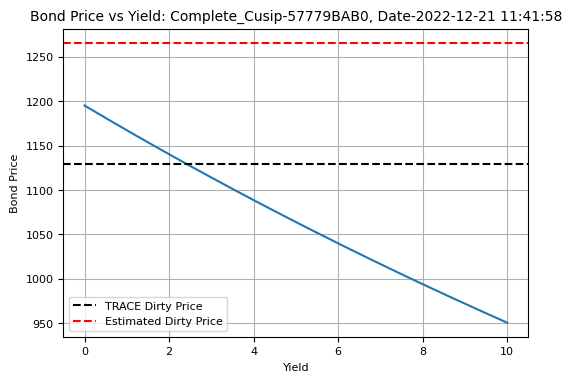

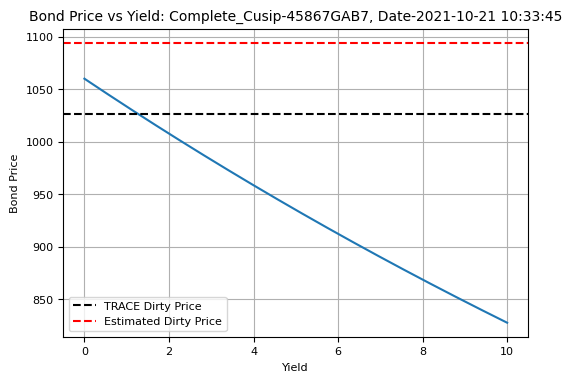

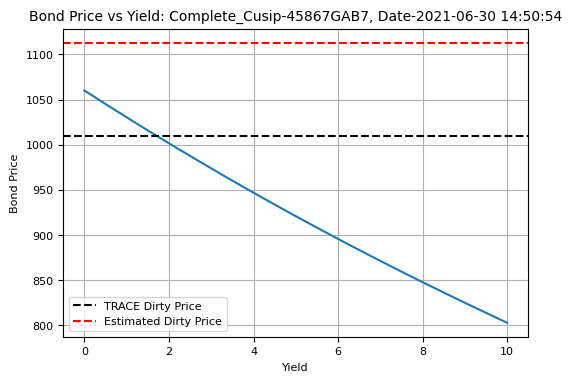

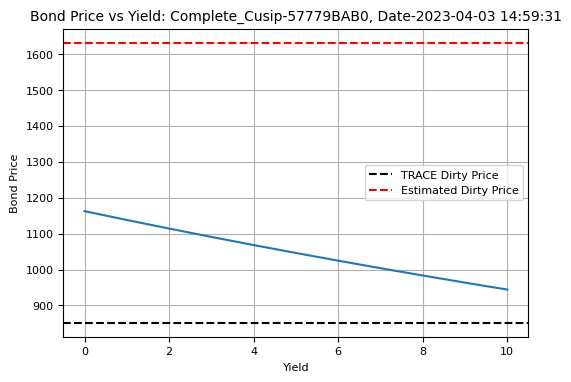

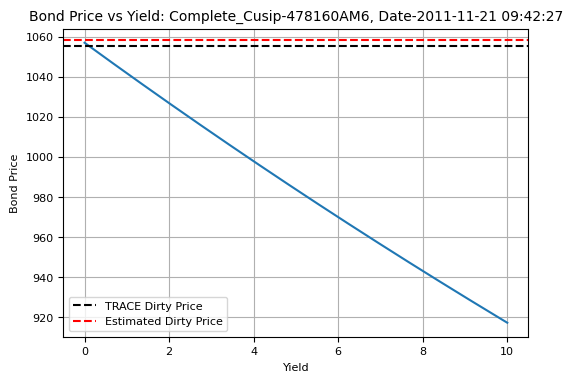

In [44]:
plotTargetPriceVSolvedPrices(fail_ex1, "estimated_dirty_price")
plotTargetPriceVSolvedPrices(fail_ex2, "estimated_dirty_price")
plotTargetPriceVSolvedPrices(fail_ex3, "estimated_dirty_price")
plotTargetPriceVSolvedPrices(fail_ex4, "estimated_dirty_price")
plotTargetPriceVSolvedPrices(fail_ex5, "estimated_dirty_price")

##### Root Scalar Success Examples

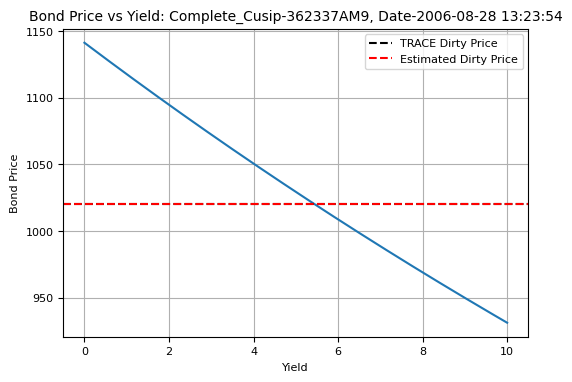

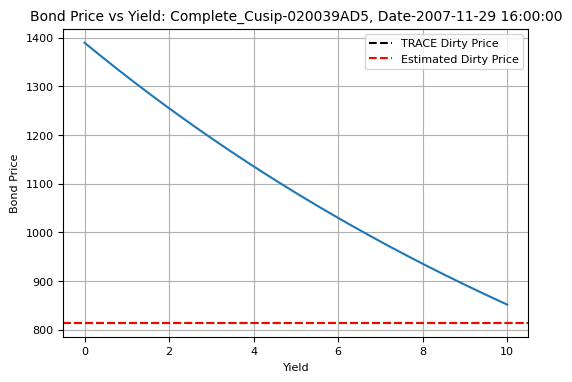

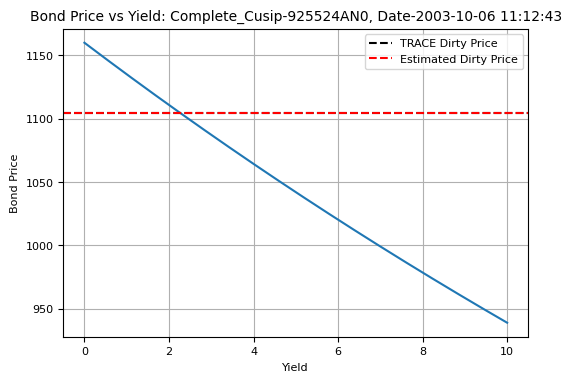

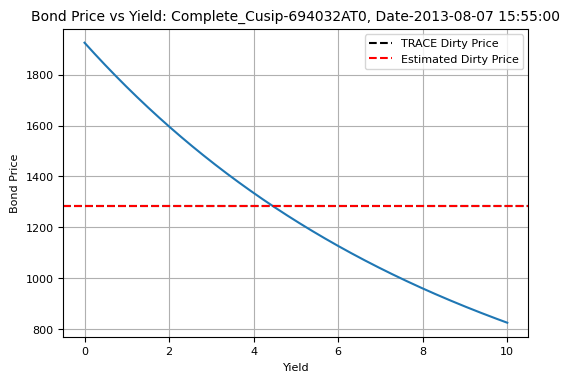

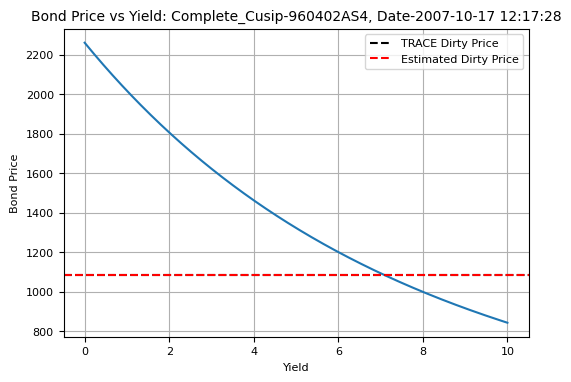

In [45]:
plotTargetPriceVSolvedPrices(success_ex1, "estimated_dirty_price")
plotTargetPriceVSolvedPrices(success_ex2, "estimated_dirty_price")
plotTargetPriceVSolvedPrices(success_ex3, "estimated_dirty_price")
plotTargetPriceVSolvedPrices(success_ex4, "estimated_dirty_price")
plotTargetPriceVSolvedPrices(success_ex5, "estimated_dirty_price")

##### Root Scalar Failure Data Point Characteristics

In [46]:
rs_fail_df[["defaulted", "denomination", "cusip_name"]].value_counts()

defaulted  denomination  cusip_name                   
N          1/1           INTERDIGITAL INC                 211
                         MAXEON SOLAR TECHNOLOGIES INC     41
                         JOHNSON & JOHNSON                 24
                         CENTURY COMMUNICATIONS CORP        5
                         INTERNATIONAL LEASE FIN CORP       2
                         VIACOM INC                         2
           2/1           3M CO                              2
           1/1           GTE CORP                           1
                         GANNETT CO INC                     1
                         EMERSON ELEC CO                    1
                         DOW CHEM CO                        1
                         COCA COLA CO                       1
                         TEXTRON FINL CORP                  1
                         UNITED DOMINION RLTY TR INC        1
                         WALMART INC                        1
Name: count, dt

In [47]:
len(rs_fail_df[rs_fail_df["trd_exctn_dt_tm"].dt.hour > 16])

1

In [48]:
len(rs_fail_df[rs_fail_df["trd_exctn_dt_tm"].dt.hour < 9])

3

### Re-Estimated (with Linear Accrual of Interest) Accrued Interest, Dirty Price, and Yield Calculations

In [49]:
#re-estimated accrued interest calculation and time tracking
re_est_acc_int_start = time.time()

daily_bullet_df["re-estimated_accrued_interest"] = daily_bullet_df.apply(
    lambda row: calcAccruedInterestLinear(
        row["coupon"],
        2,
        row["principal_amt"],
        row["dated_date"],
        row["trd_exctn_dt_tm_capped"],
        row["complete_cusip"],
        payment_schedule_dict
    ),
    axis=1
)

re_est_acc_int_end = time.time()

#re-estimated dirty price calculation and time tracking
re_est_d_price_start = time.time()

daily_bullet_df.loc[:,"re-estimated_dirty_price"] = daily_bullet_df["clean_price"] + daily_bullet_df["re-estimated_accrued_interest"]

re_est_d_price_end = time.time()

#re-estimated yield calculation and time tracking
re_est_yield_start = time.time()
#lists to track which (complete_cusip, asof_date) pairs cause root_scalar or minimize_scalar solvers to fail, with linear accrual of interest
rs_fail_id_list_2 = []
ms_fail_id_list_2 = []

#estimating yield using estimated_dirty_price, with linear accrual of interest
daily_bullet_df["re-estimated_yield"] = daily_bullet_df.apply(
    lambda row: bulletBondYieldExtractor(
        row["re-estimated_dirty_price"],
        row["coupon"],
        2,
        row["principal_amt"],
        row["trd_exctn_dt_tm_capped"],
        row["complete_cusip"],
        payment_schedule_dict,
        rs_fail_id_list_2,
        ms_fail_id_list_2
    ),
    axis=1
)

#creating pd.Series of complete cusips and asof dates that fail either solver, with linear accrual of interest, for further analysis
if len(rs_fail_id_list_2) > 0:
    rs_fail_id_complete_cusips_2, rs_fail_id_asof_dates_2 = zip(*rs_fail_id_list_2)
    rs_fail_id_complete_cusips_2 = pd.Series(rs_fail_id_complete_cusips_2)
    rs_fail_id_asof_dates_2 = pd.Series(rs_fail_id_asof_dates_2)

if len(ms_fail_id_list_2) > 0:
    ms_fail_id_complete_cusips_2, ms_fail_id_asof_dates_2 = zip(*ms_fail_id_list_2)
    ms_fail_id_complete_cusips_2 = pd.Series(ms_fail_id_complete_cusips_2)
    ms_fail_id_asof_dates_2 = pd.Series(ms_fail_id_asof_dates_2)

re_est_yield_end = time.time()

print(f"Re-Estimated Accrued Interest Calculation Time: {re_est_acc_int_end - re_est_acc_int_start:.2f} seconds")
print(f"Re-Estimated Dirty Price Calculation Time: {re_est_d_price_end - re_est_d_price_start:.2f} seconds")
print(f"Re-Estimated Yield Calculation Time: {re_est_yield_end - re_est_yield_start:.2f} seconds")

Re-Estimated Accrued Interest Calculation Time: 20.55 seconds
Re-Estimated Dirty Price Calculation Time: 0.00 seconds
Re-Estimated Yield Calculation Time: 431.79 seconds


### Comparing Re-Estimates with TRACE Implied Values

In [50]:
dirty_price_mean_abs_error_2 = np.abs(daily_bullet_df["re-estimated_dirty_price"] - daily_bullet_df["trace_dirty_price"]).mean()
dirty_price_median_abs_error_2 = np.abs(daily_bullet_df["re-estimated_dirty_price"] - daily_bullet_df["trace_dirty_price"]).median()
accrued_interest_mean_abs_error_2 = np.abs(daily_bullet_df["re-estimated_accrued_interest"] - daily_bullet_df["trace_accrued_interest"]).mean()
accrued_interest_median_abs_error_2 = np.abs(daily_bullet_df["re-estimated_accrued_interest"] - daily_bullet_df["trace_accrued_interest"]).median()
yield_mean_abs_error_2 = np.abs(daily_bullet_df["re-estimated_yield"] - daily_bullet_df["trace_yield"]).mean()
yield_median_abs_error_2 = np.abs(daily_bullet_df["re-estimated_yield"] - daily_bullet_df["trace_yield"]).median()
print(f"(Linear Accrual) Dirty Price Mean Absolute Error: ${dirty_price_mean_abs_error_2:.2f}")
print(f"(Linear Accrual) Dirty Price Median Absolute Error: ${dirty_price_median_abs_error_2:.2f}")
print(f"(Linear Accrual) Accrued Interest Mean Absolute Error: ${accrued_interest_mean_abs_error_2:.2f}")
print(f"(Linear Accrual) Accrued Interest Median Absolute Error: ${accrued_interest_median_abs_error_2:.2f}")
print(f"(Linear Accrual) Yield Mean Absolute Error: {yield_mean_abs_error_2*100:.2f} bps")
print(f"(Linear Accrual) Yield Median Absolute Error: {yield_median_abs_error_2*100:.2f} bps")

(Linear Accrual) Dirty Price Mean Absolute Error: $0.88
(Linear Accrual) Dirty Price Median Absolute Error: $0.18
(Linear Accrual) Accrued Interest Mean Absolute Error: $0.88
(Linear Accrual) Accrued Interest Median Absolute Error: $0.18
(Linear Accrual) Yield Mean Absolute Error: 27.00 bps
(Linear Accrual) Yield Median Absolute Error: 0.35 bps


In [51]:
print(f"(Linear Accrual) Num data points that failed root scalar solver: {len(rs_fail_id_list_2)}")
print(f"(Linear Accrual) Num data points that failed minimize scalar solver (no yield extracted): {len(ms_fail_id_list_2)}")

(Linear Accrual) Num data points that failed root scalar solver: 295
(Linear Accrual) Num data points that failed minimize scalar solver (no yield extracted): 0


In [52]:
daily_bullet_df[["re-estimated_dirty_price", "trace_dirty_price"]].describe()

,re-estimated_dirty_price,trace_dirty_price
count,683615.000000,683615.000000
mean,1084.287392,1084.811318
std,159.618036,159.187209
min,10.000000,3.028426
25%,1016.197708,1016.737472
50%,1078.000875,1078.670914
75%,1165.221881,1165.632989
max,10567.241750,2424.169706


In [53]:
daily_bullet_df[["re-estimated_accrued_interest", "trace_accrued_interest"]].describe()

,re-estimated_accrued_interest,trace_accrued_interest
count,683615.000000,683615.000000
mean,16.696407,17.220332
std,10.842049,19.975715
min,0.000000,-9452.538800
25%,7.534722,7.830178
50%,15.634684,16.087361
75%,24.754430,25.324173
max,62.104167,1621.421135


In [54]:
daily_bullet_df[["re-estimated_yield", "trace_yield"]].describe()

,re-estimated_yield,trace_yield
count,683615.000000,683615.000000
mean,5.711908,5.888962
std,12.789339,130.248032
min,0.000106,0.000105
25%,3.544537,3.524002
50%,5.014451,5.001000
75%,6.295354,6.278024
max,8323.881818,99999.992188


#### Evaluating Data Points (Using Linear Accrual) That Caused Root Scalar Solver to Fail

In [55]:
#obtain DataFrames of data points that failed or succeeded with the root scalar solver with re-estimated prices
fail_id_set_2 = set(zip(rs_fail_id_complete_cusips_2, pd.to_datetime(rs_fail_id_asof_dates_2)))

rs_fail_mask_2 = daily_bullet_df.apply(
    lambda row: (row["complete_cusip"], row["trd_exctn_dt_tm_capped"]) in fail_id_set_2,
    axis=1
)
rs_fail_df_2 = daily_bullet_df[rs_fail_mask_2].reset_index(drop = True)
rs_success_df_2 = daily_bullet_df[~rs_fail_mask_2].reset_index(drop = True)

print(f"Error Fraction of Sample: {len(rs_fail_df_2) / len(daily_bullet_df):.4f}")

Error Fraction of Sample: 0.0004


In [56]:
#check whether all failed data points in previous case were the same ones to fail in this case
rs_fail_df.equals(rs_fail_df_2)

False

In [70]:
#get 5 random exmaples of data points for which the root scalar solver succeeded
random_success_idx_2 = list(np.random.randint(0,len(rs_success_df_2),size=5))
success_ex1_2 = rs_success_df_2.iloc[random_success_idx_2[0]]
success_ex2_2 = rs_success_df_2.iloc[random_success_idx_2[1]]
success_ex3_2 = rs_success_df_2.iloc[random_success_idx_2[2]]
success_ex4_2 = rs_success_df_2.iloc[random_success_idx_2[3]]
success_ex5_2 = rs_success_df_2.iloc[random_success_idx_2[4]]

##### Root Scalar Success Examples 2

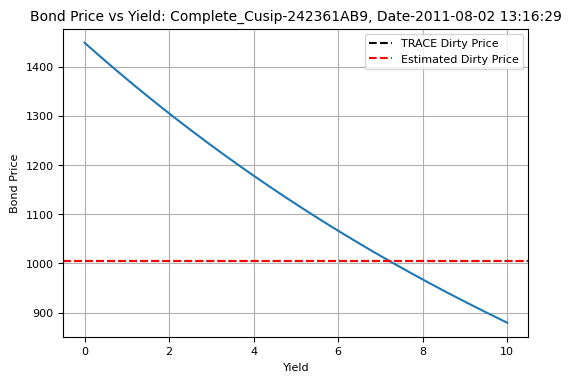

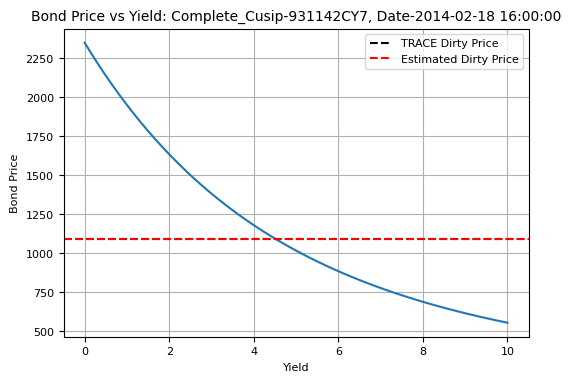

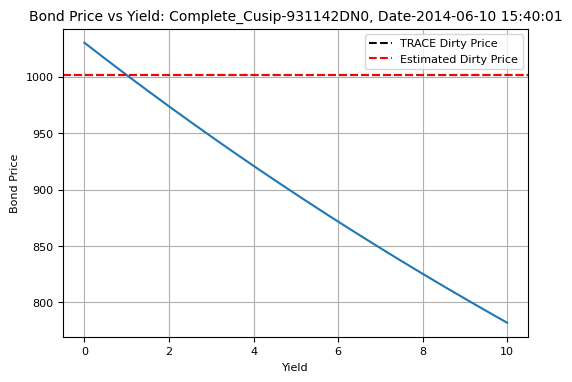

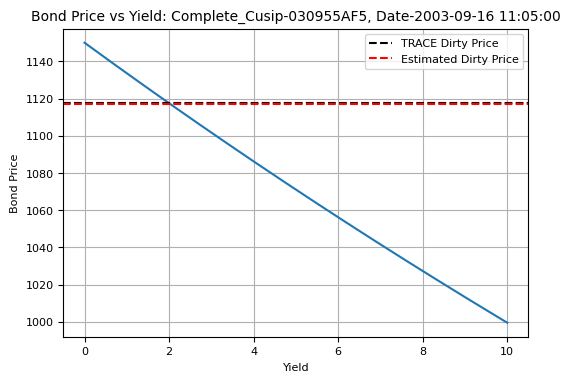

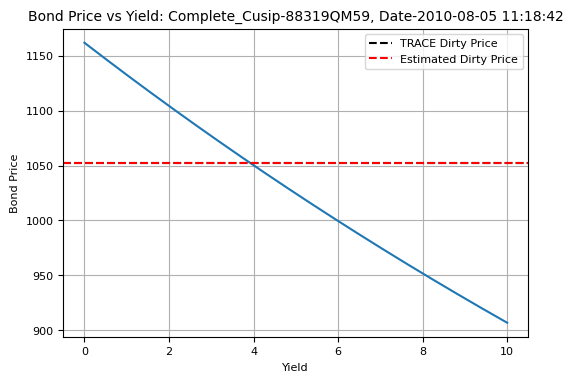

In [71]:
plotTargetPriceVSolvedPrices(success_ex1_2, "re-estimated_dirty_price")
plotTargetPriceVSolvedPrices(success_ex2_2, "re-estimated_dirty_price")
plotTargetPriceVSolvedPrices(success_ex3_2, "re-estimated_dirty_price")
plotTargetPriceVSolvedPrices(success_ex4_2, "re-estimated_dirty_price")
plotTargetPriceVSolvedPrices(success_ex5_2, "re-estimated_dirty_price")

### Calculating Duration-Matched Treasury Price

In [60]:
#duration-matched treasury price calculation and time tracking
durm_price_start = time.time()

daily_bullet_df["durm_trsy_price"] = daily_bullet_df.apply(
    lambda row: durationMatchedTreasuryPrice(
        row["coupon"],
        2,
        row["principal_amt"],
        row["trd_exctn_dt_tm_capped"],
        row["beta0"],
        row["beta1"],
        row["beta2"],
        row["beta3"],
        row["tau1"],
        row["tau2"],
        row["complete_cusip"],
        payment_schedule_dict
    ),
    axis=1
)

durm_price_end = time.time()

print(f"Duration-Matched Treasury Price Calculation Time: {durm_price_end - durm_price_start:.2f} seconds")

Duration-Matched Treasury Price Calculation Time: 485.94 seconds


In [61]:
daily_bullet_df["durm_trsy_price"].describe()

count    683051.000000
mean       1252.143506
std         197.162834
min         793.565081
25%        1095.068741
50%        1209.024617
75%        1378.938151
max        3123.651345
Name: durm_trsy_price, dtype: float64

### Saving New Daily Bullet DataFrame

#### Renaming and Keeping Relevant Columns

In [62]:
daily_bullet_df.columns

Index(['complete_cusip', 'trd_exctn_dt', 'daily_price', 'daily_volume',
       'trace_yield', 'trd_exctn_tm', 'issuer_cusip', 'cusip_name',
       'principal_amt', 'naics_code', 'announced_call', 'putable',
       'first_interest_date', 'last_interest_date', 'soft_call_make_whole',
       'bond_type', 'redeemable', 'defaulted', 'lesser_of', 'issue_cusip',
       'dated_date', 'denomination', 'offering_date', 'issuer_id', 'maturity',
       'date_subj_adjustment', 'issue_id', 'coupon', 'greater_of', 'beta0',
       'beta1', 'beta2', 'beta3', 'tau1', 'tau2', 'trd_exctn_dt_tm',
       'trd_exctn_dt_tm_capped', 'clean_price', 'estimated_accrued_interest',
       'estimated_dirty_price', 'estimated_yield', 'trace_dirty_price',
       'trace_accrued_interest', 're-estimated_accrued_interest',
       're-estimated_dirty_price', 're-estimated_yield', 'durm_trsy_price'],
      dtype='object')

In [63]:
daily_bullet_df.rename(columns={
    "estimated_accrued_interest": "expacc_accrued_interest",
    "estimated_dirty_price": "expacc_dirty_price",
    "estimated_yield": "expacc_yield"}, inplace=True)

daily_bullet_df.rename(columns={
    "re-estimated_accrued_interest": "estimated_accrued_interest",
    "re-estimated_dirty_price": "estimated_dirty_price",
    "re-estimated_yield": "estimated_yield"}, inplace=True)

In [64]:
daily_bullet_df.isna().sum() / len(daily_bullet_df)

complete_cusip                0.000000
trd_exctn_dt                  0.000000
daily_price                   0.000000
daily_volume                  0.000000
trace_yield                   0.000000
trd_exctn_tm                  0.000000
issuer_cusip                  0.000000
cusip_name                    0.000000
principal_amt                 0.000000
naics_code                    0.000000
announced_call                0.000000
putable                       0.000000
first_interest_date           0.000000
last_interest_date            0.000000
soft_call_make_whole          1.000000
bond_type                     0.000000
redeemable                    0.000000
defaulted                     0.000000
lesser_of                     1.000000
issue_cusip                   0.000000
dated_date                    0.000000
denomination                  0.000000
offering_date                 0.000000
issuer_id                     0.000000
maturity                      0.000000
date_subj_adjustment     

In [65]:
daily_bullet_df["announced_call"].value_counts()

announced_call
N    683615
Name: count, dtype: Int64

In [66]:
daily_bullet_df["redeemable"].value_counts()

redeemable
N    683615
Name: count, dtype: Int64

In [67]:
daily_bullet_df["putable"].value_counts()

putable
N    683615
Name: count, dtype: Int64

In [68]:
new_ordered_cols = [
    "complete_cusip", "issuer_cusip", "issue_cusip", "cusip_name", "issuer_id", "issue_id",
    "trd_exctn_dt_tm_capped", "trd_exctn_dt_tm", "trd_exctn_dt", "trd_exctn_tm",
    "daily_price", "daily_volume", "coupon", "clean_price", "principal_amt",
    "trace_dirty_price", "trace_yield", "trace_accrued_interest",
    "estimated_dirty_price", "estimated_yield", "estimated_accrued_interest",
    "expacc_dirty_price", "expacc_yield", "expacc_accrued_interest",
    "offering_date", "dated_date", "first_interest_date", "last_interest_date", "maturity",
    "bond_type", "defaulted", "denomination", "naics_code",
    "beta0", "beta1", "beta2", "beta3", "tau1", "tau2", "durm_trsy_price"
]

#### Saving Enhanced Daily Bullet Bond Transaction Data

In [69]:
final_daily_bullet_df = daily_bullet_df[new_ordered_cols].copy()
final_daily_bullet_df.to_parquet(processed_data_file_path + "enhanced_daily_bullet_bond_transaction_data.parquet", engine="pyarrow")